<a href="https://colab.research.google.com/github/Harihara04sudhan/naan-mudhalvan/blob/main/IBM_NM_AV_Phase2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Kaggle Package


In [ ]:
!pip install kaggle

## Uploaded the kaggle.json file from the local drive

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hari04sudhan","key":"ee10c40d15b3f8d1ff1c5bc269883274"}'}

## Creating a new kaggle foder

In [3]:
! mkdir ~/.kaggle

## Copy uploaded kaggle.json file to craeted kaggle folder

In [4]:
! cp kaggle.json ~/.kaggle/

## Permission for json file to act

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

# List the Datasets availble in Kaggle

In [6]:
! kaggle datasets list

ref                                                              title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rahulvyasm/netflix-movies-and-tv-shows                           Netflix Movies and TV Shows                          1MB  2024-04-10 09:48:38          15049        313  1.0              
sahirmaharajj/school-student-daily-attendance                    School Student Daily Attendance                      2MB  2024-04-29 19:29:56           2708         53  1.0              
muhammadibrahimqasmi/nvidia-corporation-nvda-stock-2020-to-2024  NVIDIA Corporation (NVDA) Stock | 2020 to 2024      32KB  2024-05-05 20:42:16            273         34  1.0              
kapturovalexander/time-series-for-online-store              

## Import BadODD: Bangladeshi Autonomous Driving Object Detection Dataset

In [7]:
! kaggle competitions download -c dl-enigma-10-sust-cse-carnival-2024

100% 3.22G/3.23G [02:47<00:00, 19.8MB/s]
100% 3.23G/3.23G [02:47<00:00, 20.7MB/s]


## Unzipping the Dataset

In [8]:
! unzip dl-enigma-10-sust-cse-carnival-2024.zip

Streaming output truncated to the last 5000 lines.
  inflating: dlenigma1/BadODD/labels/train/chuadanga_sirajganj1_5400.txt  
  inflating: dlenigma1/BadODD/labels/train/chuadanga_sirajganj1_5460.txt  
  inflating: dlenigma1/BadODD/labels/train/chuadanga_sirajganj1_5580.txt  
  inflating: dlenigma1/BadODD/labels/train/chuadanga_sirajganj1_5640.txt  
  inflating: dlenigma1/BadODD/labels/train/chuadanga_sirajganj1_5760.txt  
  inflating: dlenigma1/BadODD/labels/train/chuadanga_sirajganj1_5820.txt  
  inflating: dlenigma1/BadODD/labels/train/chuadanga_sirajganj1_5940.txt  
  inflating: dlenigma1/BadODD/labels/train/chuadanga_sirajganj1_6000.txt  
  inflating: dlenigma1/BadODD/labels/train/chuadanga_sirajganj1_6120.txt  
  inflating: dlenigma1/BadODD/labels/train/chuadanga_sirajganj1_6300.txt  
  inflating: dlenigma1/BadODD/labels/train/chuadanga_sirajganj1_6360.txt  
  inflating: dlenigma1/BadODD/labels/train/chuadanga_sirajganj1_6480.txt  
  inflating: dlenigma1/BadODD/labels/train/chuada

## Install pybboxes library

In [10]:
! pip install pybboxes

## Importing necessary libraries

In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import cv2
from tqdm import tqdm
import pybboxes as pbx

import matplotlib.pyplot as plt
import colorsys

## create a dataframe from the input dataset



In [12]:
with open(
    '/content/dlenigma1/BadODD/badodd.txt', 'r'
) as f:
    class_labels = [line.strip().replace('_', ' ') for line in f.readlines()]

class_label_map = {class_labels[i]: i for i in range(len(class_labels))}
class_label_map


{'auto rickshaw': 0,
 'bicycle': 1,
 'bus': 2,
 'car': 3,
 'cart vehicle': 4,
 'construction vehicle': 5,
 'motorbike': 6,
 'person': 7,
 'priority vehicle': 8,
 'three wheeler': 9,
 'train': 10,
 'truck': 11,
 'wheelchair': 12}

## Train the data

In [13]:
def get_possible_box_format(bbox, input_shape=None):
    if input_shape is None:
        return None, None, None

    voc_bbox = pbx.convert_bbox(
        bbox, from_type="yolo", to_type="voc", image_size=input_shape
    )
    coco_bbox = pbx.convert_bbox(
        bbox, from_type="yolo", to_type="coco", image_size=input_shape
    )
    yolo_bbox = ', '.join(map(str, bbox))
    return ', '.join(map(str, voc_bbox)), ', '.join(map(str, coco_bbox)), yolo_bbox

def prepare_dataframe(image_dir, label_dir):
    data = []
    for image_file in tqdm(os.listdir(image_dir), desc='Processing images'):
        img_path = os.path.join(image_dir, image_file)
        print(f"Processing image: {img_path}")
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to read image: {img_path}. Skipping...")
            continue

        img_h, img_w = img.shape[:2]
        image_id = image_file.split('.')[0]
        label_file = os.path.join(label_dir, image_id + '.txt')

        if not os.path.exists(label_file):
            print(f"Label file not found for image: {image_file}. Skipping...")
            continue

        with open(label_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                class_label, *bbox = map(float, line.strip().split())
                class_label = int(class_label)
                voc_bbox, coco_bbox, yolo_bbox = get_possible_box_format(
                    bbox, input_shape=(img_w, img_h)
                )
                if voc_bbox is None or coco_bbox is None or yolo_bbox is None:
                    print(f"Failed to get box format for image: {image_file}. Skipping...")
                    continue

                data.append({
                    'image_id': image_id,
                    'voc_bbox': voc_bbox,
                    'coco_bbox': coco_bbox,
                    'yolo_bbox': yolo_bbox,
                    'class_label': class_label,
                    'image_height': img_h,
                    'image_width': img_w,
                })

    df = pd.DataFrame(data)
    return df

# Example usage:
image_dir = '/content/dlenigma1/BadODD/images/train'
label_dir = '/content/dlenigma1/BadODD/labels/train'
train_df = prepare_dataframe(image_dir, label_dir)
print(train_df.head())


Processing images:   0%|          | 1/5896 [00:00<11:22,  8.63it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_11033.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_177.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1363.jpg


Processing images:   0%|          | 7/5896 [00:00<05:10, 18.97it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_1800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_39150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_2478.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_107882.jpg


Processing images:   0%|          | 12/5896 [00:00<05:10, 18.97it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_149131.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_36239.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna3_87.jpg


Processing images:   0%|          | 14/5896 [00:00<05:29, 17.86it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_129425.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3481.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6699.jpg


Processing images:   0%|          | 18/5896 [00:01<06:18, 15.53it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_35341.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_4897.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_7788.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_23777.jpg


Processing images:   0%|          | 23/5896 [00:01<05:18, 18.42it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_12000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna3_232.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1131.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_3068.jpg


Processing images:   0%|          | 27/5896 [00:01<05:21, 18.25it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_131930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_59321.jpg


Processing images:   1%|          | 32/5896 [00:01<04:52, 20.04it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_38999.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_7729.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_11800.jpg


Processing images:   1%|          | 35/5896 [00:01<05:08, 19.01it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_48970.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_7375.jpg


Processing images:   1%|          | 37/5896 [00:02<06:03, 16.10it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_5550.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_21180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_37642.jpg


Processing images:   1%|          | 39/5896 [00:02<07:12, 13.54it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_10411.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_37238.jpg


Processing images:   1%|          | 44/5896 [00:02<06:30, 14.98it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_35046.jpg


Processing images:   1%|          | 48/5896 [00:03<06:42, 14.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_2773.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_11977.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17936.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_9145.jpg


Processing images:   1%|          | 50/5896 [00:03<07:16, 13.39it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_14986.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_1200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_13216.jpg


Processing images:   1%|          | 55/5896 [00:03<06:19, 15.37it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_52864.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_11564.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_25134.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_19588.jpg


Processing images:   1%|          | 59/5896 [00:03<06:22, 15.25it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_16756.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4408.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_1003.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_37770.jpg


Processing images:   1%|          | 64/5896 [00:03<05:28, 17.77it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_6844.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_48144.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_117067.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_11220.jpg


Processing images:   1%|          | 68/5896 [00:04<05:52, 16.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_5640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6313.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_1003.jpg


Processing images:   1%|          | 70/5896 [00:04<07:07, 13.64it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_44073.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_42600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_28438.jpg


Processing images:   1%|          | 72/5896 [00:04<10:15,  9.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_117401.jpg


Processing images:   1%|▏         | 74/5896 [00:05<12:03,  8.05it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_18390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_36049.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_4860.jpg


Processing images:   1%|▏         | 76/5896 [00:05<15:08,  6.40it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16980.jpg


Processing images:   1%|▏         | 77/5896 [00:05<17:15,  5.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_121910.jpg


Processing images:   1%|▏         | 78/5896 [00:06<20:31,  4.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_3031.jpg


Processing images:   1%|▏         | 80/5896 [00:06<20:41,  4.69it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7250.jpg


Processing images:   1%|▏         | 82/5896 [00:07<21:14,  4.56it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7729.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_480.jpg


Processing images:   1%|▏         | 83/5896 [00:07<21:51,  4.43it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6195.jpg


Processing images:   1%|▏         | 84/5896 [00:07<24:01,  4.03it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7685.jpg


Processing images:   1%|▏         | 86/5896 [00:08<20:08,  4.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_4661.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11550.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_3240.jpg


Processing images:   2%|▏         | 90/5896 [00:08<12:39,  7.64it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_5336.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_1440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1044.jpg


Processing images:   2%|▏         | 92/5896 [00:08<11:27,  8.45it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43365.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_12692.jpg


Processing images:   2%|▏         | 94/5896 [00:08<11:52,  8.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna3_696.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_8100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_16107.jpg


Processing images:   2%|▏         | 100/5896 [00:09<06:09, 15.68it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_23610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_36521.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_9450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39766.jpg


Processing images:   2%|▏         | 105/5896 [00:09<05:39, 17.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2668.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_72645.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3953.jpg


Processing images:   2%|▏         | 109/5896 [00:09<06:18, 15.27it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_25901.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_2006.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4930.jpg


Processing images:   2%|▏         | 113/5896 [00:09<05:55, 16.26it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_1475.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_49766.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_5782.jpg


Processing images:   2%|▏         | 116/5896 [00:10<05:34, 17.29it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_27570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45666.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_1980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_20119.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_74315.jpg


Processing images:   2%|▏         | 122/5896 [00:10<05:07, 18.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_31020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_25842.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_4484.jpg


Processing images:   2%|▏         | 124/5896 [00:10<05:57, 16.12it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_6608.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33925.jpg


Processing images:   2%|▏         | 126/5896 [00:10<08:29, 11.33it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_142785.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_5487.jpg


Processing images:   2%|▏         | 130/5896 [00:11<08:37, 11.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_148296.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3103.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_24426.jpg


Processing images:   2%|▏         | 132/5896 [00:11<08:34, 11.21it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_26100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_8673.jpg


Processing images:   2%|▏         | 134/5896 [00:11<10:05,  9.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9480.jpg


Processing images:   2%|▏         | 136/5896 [00:11<10:08,  9.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_155644.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5771.jpg


Processing images:   2%|▏         | 138/5896 [00:12<11:44,  8.18it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_158650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6061.jpg


Processing images:   2%|▏         | 140/5896 [00:12<09:56,  9.65it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_5428.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_11092.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_11328.jpg


Processing images:   2%|▏         | 144/5896 [00:12<08:21, 11.48it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_1080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1305.jpg


Processing images:   3%|▎         | 149/5896 [00:12<06:46, 14.15it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_4484.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_18870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_34736.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_150801.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_9263.jpg


Processing images:   3%|▎         | 154/5896 [00:13<05:51, 16.33it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_1440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_78490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_15300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3915.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6195.jpg


Processing images:   3%|▎         | 157/5896 [00:13<05:39, 16.92it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_44309.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_21780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_32400.jpg


Processing images:   3%|▎         | 163/5896 [00:13<04:25, 21.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_40179.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_48085.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_6900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_6431.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_6608.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9831.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_8149.jpg


Processing images:   3%|▎         | 170/5896 [00:13<03:34, 26.67it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38645.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_10440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33807.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_19950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8909.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_12095.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_4200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_18990.jpg


Processing images:   3%|▎         | 178/5896 [00:14<03:10, 30.00it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_4740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_19470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_20207.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_3900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17995.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_93687.jpg


Processing images:   3%|▎         | 186/5896 [00:14<02:58, 31.95it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_11310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_17340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_118.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_19824.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_6179.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_75985.jpg


Processing images:   3%|▎         | 194/5896 [00:14<03:06, 30.60it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_32908.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_136940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_16620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_13193.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3277.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_113894.jpg


Processing images:   3%|▎         | 198/5896 [00:14<03:09, 30.05it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_100868.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_153139.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_19942.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_3776.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15694.jpg


Processing images:   3%|▎         | 206/5896 [00:15<03:09, 30.04it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6873.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2832.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_4175.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2478.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13157.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1363.jpg


Processing images:   4%|▎         | 214/5896 [00:15<03:05, 30.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_29.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2655.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4379.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_38291.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11741.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1860.jpg


Processing images:   4%|▎         | 218/5896 [00:15<03:02, 31.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_145.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_1298.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_406.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_28578.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11623.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2291.jpg


Processing images:   4%|▍         | 226/5896 [00:15<03:02, 31.02it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_3330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_36462.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_33341.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26609.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_19234.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7047.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_3658.jpg


Processing images:   4%|▍         | 234/5896 [00:15<02:57, 31.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_4470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_1711.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3857.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_1410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_20768.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_45961.jpg


Processing images:   4%|▍         | 243/5896 [00:16<02:40, 35.15it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_2640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_17759.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_34869.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39707.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5550.jpg


Processing images:   4%|▍         | 251/5896 [00:16<02:42, 34.76it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6061.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_12390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_126252.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2460.jpg


Processing images:   4%|▍         | 259/5896 [00:16<02:44, 34.33it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4779.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_8178.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_3780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4408.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_32610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_55047.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_12060.jpg


Processing images:   4%|▍         | 263/5896 [00:16<02:47, 33.55it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6815.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1073.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_3780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_10443.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39825.jpg


Processing images:   5%|▍         | 271/5896 [00:16<02:49, 33.25it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11682.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_118403.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_15720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_29100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_26130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_5487.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_7670.jpg


Processing images:   5%|▍         | 279/5896 [00:17<02:46, 33.66it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_26880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3016.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_1503.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4263.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5278.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_8201.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2490.jpg


Processing images:   5%|▍         | 287/5896 [00:17<02:40, 34.94it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17550.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_2183.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_25740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2655.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_22007.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16860.jpg


Processing images:   5%|▌         | 295/5896 [00:17<02:40, 34.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_100033.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_12900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_1080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_25860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6032.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_11790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4176.jpg


Processing images:   5%|▌         | 299/5896 [00:17<02:51, 32.70it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4669.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_27730.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_29640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_9960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_8700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_7257.jpg


Processing images:   5%|▌         | 307/5896 [00:18<03:12, 28.99it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_10500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6785.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_21710.jpg


Processing images:   5%|▌         | 310/5896 [00:18<03:34, 26.00it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_27960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50209.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_127254.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13983.jpg


Processing images:   5%|▌         | 316/5896 [00:18<04:00, 23.24it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_767.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2088.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2233.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_20640.jpg


Processing images:   5%|▌         | 322/5896 [00:18<04:28, 20.73it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_49973.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3712.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_21889.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_42716.jpg


Processing images:   6%|▌         | 325/5896 [00:19<04:25, 21.01it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_649.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_7670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_60.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_80995.jpg


Processing images:   6%|▌         | 328/5896 [00:19<04:29, 20.66it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_12685.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_1260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_38645.jpg


Processing images:   6%|▌         | 334/5896 [00:19<04:33, 20.32it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43306.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_16579.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3393.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_22479.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42480.jpg


Processing images:   6%|▌         | 337/5896 [00:19<04:38, 19.97it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_139445.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_26137.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6903.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_116566.jpg


Processing images:   6%|▌         | 342/5896 [00:19<04:46, 19.41it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_531.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_102204.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_29400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_4080.jpg


Processing images:   6%|▌         | 347/5896 [00:20<04:50, 19.09it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5713.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_12921.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2891.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_13511.jpg


Processing images:   6%|▌         | 353/5896 [00:20<04:22, 21.12it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_133099.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_16560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_12480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_1298.jpg


Processing images:   6%|▌         | 356/5896 [00:20<04:34, 20.22it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_46728.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_8083.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_18480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30031.jpg


Processing images:   6%|▌         | 362/5896 [00:20<04:35, 20.08it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_11210.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_42752.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_40269.jpg


Processing images:   6%|▌         | 365/5896 [00:21<04:31, 20.35it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_16933.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_295.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_3481.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14337.jpg


Processing images:   6%|▋         | 372/5896 [00:21<03:35, 25.68it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_754.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_3186.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_19410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_11370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_27600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_52438.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_9204.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7453.jpg


Processing images:   6%|▋         | 381/5896 [00:21<02:49, 32.57it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_21660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_5605.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_54442.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_33120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_12660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_13440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5133.jpg


Processing images:   7%|▋         | 389/5896 [00:21<02:44, 33.53it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1334.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_20460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_20768.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_9440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_48734.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_11022.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_35518.jpg


Processing images:   7%|▋         | 397/5896 [00:21<02:52, 31.93it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_13380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_20709.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_22066.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_20060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_3270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_60621.jpg


Processing images:   7%|▋         | 405/5896 [00:22<02:54, 31.53it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13216.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_1062.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38173.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_135771.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19140.jpg


Processing images:   7%|▋         | 409/5896 [00:22<02:51, 32.00it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_27000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_42952.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1247.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_14750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21653.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_28497.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_46551.jpg


Processing images:   7%|▋         | 417/5896 [00:22<02:52, 31.82it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2581.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_38173.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_52271.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_153974.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_780.jpg


Processing images:   7%|▋         | 425/5896 [00:22<02:48, 32.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_56780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_10650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_24681.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_3304.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_13924.jpg


Processing images:   7%|▋         | 434/5896 [00:23<02:48, 32.39it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_15090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_130594.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_23380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2773.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_3304.jpg


Processing images:   7%|▋         | 438/5896 [00:23<02:46, 32.71it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_16402.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_89345.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_29205.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_37465.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_60.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_42270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7680.jpg


Processing images:   8%|▊         | 446/5896 [00:23<02:35, 35.12it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_26280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_42060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43955.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_53218.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_6844.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_708.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_413.jpg

Processing images:   8%|▊         | 454/5896 [00:23<02:36, 34.73it/s]


Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_38468.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_14970.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_17700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_16440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_79659.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_10679.jpg


Processing images:   8%|▊         | 462/5896 [00:23<02:48, 32.21it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_26137.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38586.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15517.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_2714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_1200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_129258.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_27966.jpg


Processing images:   8%|▊         | 466/5896 [00:24<02:47, 32.51it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_53607.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_28020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_145457.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_45725.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_132932.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_28792.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_3068.jpg


Processing images:   8%|▊         | 474/5896 [00:24<02:52, 31.42it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26432.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_19080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3009.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_4012.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_7316.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7395.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4234.jpg


Processing images:   8%|▊         | 482/5896 [00:24<02:45, 32.66it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_25488.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_20640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_2478.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_42420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_5520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_4680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21712.jpg


Processing images:   8%|▊         | 490/5896 [00:24<02:46, 32.45it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_5100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_17130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_12331.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_3717.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_15163.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_8040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_2832.jpg


Processing images:   8%|▊         | 494/5896 [00:24<02:42, 33.23it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46787.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_14691.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_143954.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_17869.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_35577.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6525.jpg


Processing images:   9%|▊         | 502/5896 [00:25<02:46, 32.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_29913.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_24839.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_10325.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_19470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34043.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_10738.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_18120.jpg


Processing images:   9%|▊         | 510/5896 [00:25<02:42, 33.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_21376.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_45017.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_25016.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_30720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22800.jpg


Processing images:   9%|▉         | 518/5896 [00:25<02:51, 31.44it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_5280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_97194.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_11040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39589.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4205.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_35931.jpg


Processing images:   9%|▉         | 522/5896 [00:25<02:47, 32.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_1200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_15720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_4897.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6351.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_48063.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_29100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_23880.jpg


Processing images:   9%|▉         | 530/5896 [00:26<03:00, 29.76it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_58951.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_5192.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_6254.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_23382.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6380.jpg


Processing images:   9%|▉         | 537/5896 [00:26<03:03, 29.17it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_9558.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_40748.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3799.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_7080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_67134.jpg


Processing images:   9%|▉         | 544/5896 [00:26<02:54, 30.59it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_56640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1595.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_5074.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_22066.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_28530.jpg


Processing images:   9%|▉         | 548/5896 [00:26<02:46, 32.10it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_17820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3451.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_3780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_80327.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_107381.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16260.jpg


Processing images:   9%|▉         | 556/5896 [00:26<02:38, 33.60it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_2891.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_1015.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10679.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16050.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5104.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_58.jpg


Processing images:  10%|▉         | 564/5896 [00:27<02:56, 30.18it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_5017.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_16500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8142.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41654.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17523.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_37909.jpg


Processing images:  10%|▉         | 572/5896 [00:27<02:46, 31.99it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_3245.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8062.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_8323.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_8310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_8201.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_13865.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12780.jpg


Processing images:  10%|▉         | 576/5896 [00:27<02:43, 32.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_28223.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_10266.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_4140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_141950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6726.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_13806.jpg


Processing images:  10%|▉         | 584/5896 [00:27<02:50, 31.24it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_7080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_472.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_56345.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17464.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_9322.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_68971.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_30444.jpg


Processing images:  10%|█         | 592/5896 [00:28<02:45, 31.96it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_12626.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_35518.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_29913.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14691.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_147795.jpg


Processing images:  10%|█         | 600/5896 [00:28<02:40, 33.00it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_3000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_21870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_18526.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_8083.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_35105.jpg


Processing images:  10%|█         | 604/5896 [00:28<02:36, 33.76it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_5015.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_1200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_236.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6322.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_40651.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3857.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_113059.jpg


Processing images:  10%|█         | 612/5896 [00:28<02:42, 32.45it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_34220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_26550.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_40297.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1943.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42067.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_40002.jpg


Processing images:  11%|█         | 620/5896 [00:28<02:39, 32.98it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6148.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_23820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5251.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_147962.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_21540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2360.jpg


Processing images:  11%|█         | 628/5896 [00:29<02:47, 31.45it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_12331.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_7316.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8496.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_2175.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_61289.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_3006.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3712.jpg


Processing images:  11%|█         | 632/5896 [00:29<02:48, 31.24it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_31980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_42867.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_33276.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15812.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7830.jpg


Processing images:  11%|█         | 640/5896 [00:29<02:39, 32.94it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_23340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_3835.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3335.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_10860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_12095.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_80160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31020.jpg


Processing images:  11%|█         | 648/5896 [00:29<02:32, 34.33it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_16225.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_1140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_9971.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_20670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_43837.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_13393.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_11800.jpg


Processing images:  11%|█         | 656/5896 [00:30<02:31, 34.49it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2006.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_156813.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_24485.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_16021.jpg


Processing images:  11%|█▏        | 664/5896 [00:30<02:45, 31.66it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_14514.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6409.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17877.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_28260.jpg


Processing images:  11%|█▏        | 668/5896 [00:30<02:35, 33.69it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30562.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_89679.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_41550.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6612.jpg


Processing images:  11%|█▏        | 677/5896 [00:30<02:40, 32.56it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_41005.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6351.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_17535.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6372.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_14750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_14455.jpg


Processing images:  12%|█▏        | 685/5896 [00:30<02:41, 32.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_3953.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_2478.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_30208.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_19765.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5162.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4779.jpg


Processing images:  12%|█▏        | 689/5896 [00:31<02:49, 30.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1015.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_2655.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_23718.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46964.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1620.jpg


Processing images:  12%|█▏        | 693/5896 [00:31<03:00, 28.84it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_23430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1653.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4602.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4800.jpg


Processing images:  12%|█▏        | 699/5896 [00:31<03:40, 23.59it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_45902.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_12154.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_13452.jpg


Processing images:  12%|█▏        | 702/5896 [00:31<04:03, 21.33it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_31506.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5074.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_34640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1856.jpg


Processing images:  12%|█▏        | 708/5896 [00:32<04:08, 20.90it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5945.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_25080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_29795.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_28733.jpg


Processing images:  12%|█▏        | 714/5896 [00:32<04:17, 20.11it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_12600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_30149.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_11092.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_1475.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_377.jpg


Processing images:  12%|█▏        | 717/5896 [00:32<04:34, 18.89it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3277.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_1711.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20880.jpg


Processing images:  12%|█▏        | 722/5896 [00:32<04:25, 19.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_40887.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_140781.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_23777.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_62363.jpg


Processing images:  12%|█▏        | 727/5896 [00:32<04:13, 20.36it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_69639.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_1620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5428.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7337.jpg


Processing images:  12%|█▏        | 730/5896 [00:33<04:18, 20.00it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2668.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_87842.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_319.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_42539.jpg


Processing images:  12%|█▏        | 735/5896 [00:33<04:23, 19.57it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_59531.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_25193.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_77655.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2349.jpg


Processing images:  13%|█▎        | 740/5896 [00:33<04:33, 18.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_3009.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_3481.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_73981.jpg


Processing images:  13%|█▎        | 744/5896 [00:33<04:32, 18.92it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_28261.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_52156.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_111556.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_21480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_22860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22890.jpg

Processing images:  13%|█▎        | 748/5896 [00:33<03:31, 24.32it/s]


Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_11857.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_24840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_86673.jpg


Processing images:  13%|█▎        | 754/5896 [00:34<04:01, 21.27it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_32398.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_472.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43247.jpg


Processing images:  13%|█▎        | 761/5896 [00:34<03:13, 26.59it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_7434.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_2790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_2040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_21771.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1769.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9000.jpg


Processing images:  13%|█▎        | 769/5896 [00:34<02:49, 30.24it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_12690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3625.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_24367.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_9870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_1160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12331.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2465.jpg


Processing images:  13%|█▎        | 773/5896 [00:34<02:51, 29.88it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43601.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8932.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_11690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_119071.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_14927.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_4980.jpg


Processing images:  13%|█▎        | 781/5896 [00:35<02:42, 31.42it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_29382.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_5820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_6254.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4727.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_119906.jpg


Processing images:  13%|█▎        | 789/5896 [00:35<02:47, 30.41it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4785.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_11623.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_40414.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_20880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1860.jpg


Processing images:  13%|█▎        | 793/5896 [00:35<02:49, 30.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_99866.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_14370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_7788.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_11850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_12930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1653.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_37878.jpg


Processing images:  14%|█▎        | 801/5896 [00:35<02:39, 31.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_7080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_10800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3186.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_1972.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_6810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6780.jpg


Processing images:  14%|█▎        | 809/5896 [00:36<02:28, 34.25it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_27120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_137107.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_11760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_134602.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_23187.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6690.jpg


Processing images:  14%|█▍        | 818/5896 [00:36<02:18, 36.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_110053.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_23010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_28500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_27090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_11446.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_8791.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_5678.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_130260.jpg


Processing images:  14%|█▍        | 826/5896 [00:36<02:30, 33.79it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_551.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_3660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_1062.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_84335.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_34397.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_6726.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_30960.jpg


Processing images:  14%|█▍        | 834/5896 [00:36<02:33, 32.88it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_44545.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_22420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_35990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_31897.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_29940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_12540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_2160.jpg


Processing images:  14%|█▍        | 842/5896 [00:36<02:27, 34.29it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_68136.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_25320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_15660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_10020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_826.jpg


Processing images:  14%|█▍        | 846/5896 [00:37<02:30, 33.51it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_2773.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7493.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_61301.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17523.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_25783.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_5310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_55110.jpg


Processing images:  14%|█▍        | 854/5896 [00:37<02:27, 34.28it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_40650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_1593.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_97361.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_56404.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_41568.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3712.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8310.jpg


Processing images:  15%|█▍        | 862/5896 [00:37<02:36, 32.17it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_62304.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3245.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_493.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_2340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna3_290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_5100.jpg


Processing images:  15%|█▍        | 870/5896 [00:37<02:25, 34.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_47318.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_236.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7714.jpg


Processing images:  15%|█▍        | 878/5896 [00:38<02:35, 32.29it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_4366.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_22184.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_18349.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_2006.jpg


Processing images:  15%|█▌        | 886/5896 [00:38<02:38, 31.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_121075.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_81162.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18113.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_2160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway4_649.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_61419.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_23895.jpg


Processing images:  15%|█▌        | 890/5896 [00:38<02:36, 31.91it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7685.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4698.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_2760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_10380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_2714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49678.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_4661.jpg


Processing images:  15%|█▌        | 899/5896 [00:38<02:28, 33.73it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_45925.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_29160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_43365.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_18240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1218.jpg


Processing images:  15%|█▌        | 907/5896 [00:38<02:26, 33.97it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_4838.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_8910.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_17877.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1682.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_167.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_2124.jpg


Processing images:  15%|█▌        | 911/5896 [00:39<02:34, 32.34it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6136.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_334.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_20473.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_18630.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_2880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_319.jpg


Processing images:  16%|█▌        | 920/5896 [00:39<02:36, 31.87it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_25075.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_3245.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_23836.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_16980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_9617.jpg


Processing images:  16%|█▌        | 928/5896 [00:39<02:32, 32.55it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12685.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_4602.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_18537.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_1829.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5713.jpg


Processing images:  16%|█▌        | 932/5896 [00:39<02:34, 32.13it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_50032.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_63307.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_3127.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_4980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_21360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_20178.jpg


Processing images:  16%|█▌        | 940/5896 [00:39<02:37, 31.53it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_46256.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_17051.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_76152.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_108383.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_37052.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_41536.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2697.jpg

Processing images:  16%|█▌        | 948/5896 [00:40<02:40, 30.82it/s]


Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_107047.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39766.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_16815.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_986.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_128256.jpg


Processing images:  16%|█▌        | 952/5896 [00:40<02:42, 30.35it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7906.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_668.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_20296.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_34456.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_20591.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3364.jpg


Processing images:  16%|█▋        | 960/5896 [00:40<02:43, 30.28it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_48931.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_120741.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_5307.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_16380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_40050.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_91015.jpg


Processing images:  16%|█▋        | 968/5896 [00:40<02:40, 30.68it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39707.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_53395.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_11151.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_1440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13806.jpg


Processing images:  16%|█▋        | 972/5896 [00:41<02:43, 30.05it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_15540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2006.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1305.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10679.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_36462.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_1320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45076.jpg


Processing images:  17%|█▋        | 980/5896 [00:41<02:38, 30.96it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_4956.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8468.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_33040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_11280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_32820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_6667.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_450.jpg


Processing images:  17%|█▋        | 989/5896 [00:41<02:20, 34.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30326.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_10620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_27388.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_5782.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5916.jpg


Processing images:  17%|█▋        | 997/5896 [00:41<02:34, 31.80it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_32640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_23128.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_464.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_2301.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_9440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_236.jpg


Processing images:  17%|█▋        | 1001/5896 [00:41<02:38, 30.86it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna2_116.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2465.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_19352.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_9676.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_14396.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_41418.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_148797.jpg


Processing images:  17%|█▋        | 1009/5896 [00:42<02:32, 32.04it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_37241.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_47259.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_12840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_5075.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5191.jpg


Processing images:  17%|█▋        | 1017/5896 [00:42<02:44, 29.59it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_24839.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_12240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33571.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_42251.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_5790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_22715.jpg


Processing images:  17%|█▋        | 1025/5896 [00:42<02:24, 33.64it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_18585.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_11430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1044.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_2190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7198.jpg


Processing images:  18%|█▊        | 1033/5896 [00:42<02:28, 32.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_72144.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43483.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26845.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_13620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_17940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26491.jpg


Processing images:  18%|█▊        | 1037/5896 [00:43<02:37, 30.91it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_667.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3304.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11859.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_531.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_31800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_5369.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_28920.jpg


Processing images:  18%|█▊        | 1045/5896 [00:43<02:35, 31.10it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_4956.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_18821.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_8555.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_8437.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_1357.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_12272.jpg


Processing images:  18%|█▊        | 1053/5896 [00:43<02:38, 30.49it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_1180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_8160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_43955.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_30090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7975.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_2460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_13806.jpg


Processing images:  18%|█▊        | 1061/5896 [00:43<02:33, 31.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_13360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6630.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_23718.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_26019.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_40356.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2088.jpg


Processing images:  18%|█▊        | 1065/5896 [00:43<02:25, 33.23it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_522.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_2040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_25980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2842.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_7375.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2301.jpg


Processing images:  18%|█▊        | 1073/5896 [00:44<02:26, 33.03it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_98029.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_18644.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16170.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_41580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9512.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_150300.jpg


Processing images:  18%|█▊        | 1081/5896 [00:44<02:44, 29.35it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_12390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4959.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15989.jpg


Processing images:  18%|█▊        | 1085/5896 [00:44<03:11, 25.13it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2726.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_8496.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_177.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1769.jpg


Processing images:  19%|█▊        | 1091/5896 [00:44<03:24, 23.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_34140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_37260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5336.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_46020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12744.jpg


Processing images:  19%|█▊        | 1094/5896 [00:45<03:29, 22.87it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2639.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_5580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_26460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_4080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19860.jpg


Processing images:  19%|█▊        | 1100/5896 [00:45<03:45, 21.30it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_7552.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_4543.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6786.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_44427.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_23246.jpg


Processing images:  19%|█▉        | 1106/5896 [00:45<03:42, 21.48it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_26310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_493.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_14700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_61957.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_54988.jpg


Processing images:  19%|█▉        | 1109/5896 [00:45<03:39, 21.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_354.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_32332.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_10560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_41359.jpg


Processing images:  19%|█▉        | 1115/5896 [00:46<03:32, 22.55it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_21480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_6570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_6510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15104.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_18113.jpg


Processing images:  19%|█▉        | 1121/5896 [00:46<03:41, 21.60it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2065.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_23880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_29220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7424.jpg


Processing images:  19%|█▉        | 1124/5896 [00:46<04:00, 19.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_6960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_73480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_4800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1827.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16800.jpg


Processing images:  19%|█▉        | 1130/5896 [00:46<04:04, 19.50it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_28500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4031.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1044.jpg


Processing images:  19%|█▉        | 1132/5896 [00:46<04:20, 18.29it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_21720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_12690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2610.jpg


Processing images:  19%|█▉        | 1137/5896 [00:47<04:22, 18.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_2280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_8378.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_40260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_52333.jpg


Processing images:  19%|█▉        | 1143/5896 [00:47<03:26, 23.06it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_22680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_40533.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_47731.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_45076.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_28202.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_146960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_11940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1380.jpg


Processing images:  20%|█▉        | 1151/5896 [00:47<02:41, 29.43it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_30420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_39058.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_5160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_12191.jpg


Processing images:  20%|█▉        | 1159/5896 [00:47<02:41, 29.34it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_3953.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_45424.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_15989.jpg


Processing images:  20%|█▉        | 1167/5896 [00:48<02:29, 31.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_12600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_1980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43896.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_38970.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_15045.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1260.jpg


Processing images:  20%|█▉        | 1171/5896 [00:48<02:28, 31.76it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_9526.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_9971.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_3422.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4002.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_7139.jpg


Processing images:  20%|██        | 1180/5896 [00:48<02:21, 33.23it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna3_725.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_25429.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15635.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_27000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_944.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_34207.jpg


Processing images:  20%|██        | 1188/5896 [00:48<02:21, 33.28it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_5520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_1888.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_43011.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2478.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_13440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_67301.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_14986.jpg


Processing images:  20%|██        | 1192/5896 [00:48<02:29, 31.55it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_56817.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3219.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_47318.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_71309.jpg


Processing images:  20%|██        | 1200/5896 [00:49<02:26, 31.98it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_11387.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_44604.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_45843.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_10410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3599.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_5723.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_2220.jpg


Processing images:  20%|██        | 1208/5896 [00:49<02:35, 30.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_124415.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_14700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_6960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_44756.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_21181.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_928.jpg


Processing images:  21%|██        | 1212/5896 [00:49<02:33, 30.53it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_14696.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_36462.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_27317.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_1950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_10207.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_15104.jpg


Processing images:  21%|██        | 1221/5896 [00:49<02:16, 34.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_44610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_18939.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_158817.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_2400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_32037.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_18330.jpg


Processing images:  21%|██        | 1229/5896 [00:50<02:17, 33.88it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2006.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_19529.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_44400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_32760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_1475.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3894.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_91182.jpg


Processing images:  21%|██        | 1237/5896 [00:50<02:18, 33.68it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_14040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_134435.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7163.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5539.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_1320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_19920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45843.jpg


Processing images:  21%|██        | 1245/5896 [00:50<02:14, 34.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_13511.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_3835.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4205.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_15399.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_17610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_57289.jpg


Processing images:  21%|██        | 1249/5896 [00:50<02:19, 33.29it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_2714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_32981.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_7611.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_1003.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_8294.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_8496.jpg


Processing images:  21%|██▏       | 1257/5896 [00:50<02:24, 32.02it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_1180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17051.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_48380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7366.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_1620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6900.jpg


Processing images:  21%|██▏       | 1265/5896 [00:51<02:17, 33.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_6000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14986.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4727.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_28497.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8787.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38704.jpg


Processing images:  22%|██▏       | 1274/5896 [00:51<02:11, 35.21it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_40120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_40410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_40297.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_4200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_13050.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_10443.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_32155.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_22020.jpg


Processing images:  22%|██▏       | 1280/5896 [00:51<02:01, 37.94it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_3630.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_8460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_10325.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_14573.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_3180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_464.jpg


Processing images:  22%|██▏       | 1288/5896 [00:51<02:14, 34.15it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_38704.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41182.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_4071.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_2400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9454.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_826.jpg


Processing images:  22%|██▏       | 1296/5896 [00:52<02:25, 31.56it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_5280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2581.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_17640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_27140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_1180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_61006.jpg


Processing images:  22%|██▏       | 1300/5896 [00:52<02:29, 30.67it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_16107.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4292.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_177.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51743.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_19320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night4_1728.jpg


Processing images:  22%|██▏       | 1308/5896 [00:52<02:26, 31.41it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_109385.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_30680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_49678.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_17700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_15576.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_531.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8178.jpg


Processing images:  22%|██▏       | 1316/5896 [00:52<02:28, 30.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_25980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_2171.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_95691.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_17820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6844.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1595.jpg


Processing images:  22%|██▏       | 1325/5896 [00:53<02:12, 34.57it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_39750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_30030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_14130.jpg


Processing images:  23%|██▎       | 1333/5896 [00:53<02:15, 33.70it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_4543.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5015.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_23190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_13747.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_12567.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_13629.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_23460.jpg


Processing images:  23%|██▎       | 1338/5896 [00:53<02:00, 37.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2730.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_9735.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna1_480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_4342.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_58617.jpg


Processing images:  23%|██▎       | 1346/5896 [00:53<02:12, 34.30it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_13865.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_20370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_87174.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_146459.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6844.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_23305.jpg


Processing images:  23%|██▎       | 1354/5896 [00:53<02:25, 31.29it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_1380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_57615.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_8850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_61790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51625.jpg


Processing images:  23%|██▎       | 1358/5896 [00:54<02:26, 31.08it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_98530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_33394.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_12862.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_55165.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49383.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_93019.jpg


Processing images:  23%|██▎       | 1366/5896 [00:54<02:24, 31.44it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_16867.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7743.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_8909.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9390.jpg


Processing images:  23%|██▎       | 1374/5896 [00:54<02:20, 32.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4425.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_37760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8845.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2958.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_28556.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_39589.jpg


Processing images:  23%|██▎       | 1382/5896 [00:54<02:23, 31.50it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_6372.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17995.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_32732.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_783.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_20580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2419.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_23714.jpg


Processing images:  24%|██▎       | 1386/5896 [00:54<02:29, 30.08it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_75317.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_26314.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15694.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_8142.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_20591.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_30561.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3915.jpg


Processing images:  24%|██▎       | 1394/5896 [00:55<02:31, 29.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1131.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_11505.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_61919.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_56758.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_13200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_13452.jpg


Processing images:  24%|██▍       | 1402/5896 [00:55<02:28, 30.18it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15458.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_60593.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_40356.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_13098.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34869.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_40592.jpg


Processing images:  24%|██▍       | 1406/5896 [00:55<02:32, 29.36it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_21299.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6467.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_2760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_18113.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_17910.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_885.jpg


Processing images:  24%|██▍       | 1414/5896 [00:55<02:24, 30.99it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4843.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_1770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_50434.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_13860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_3186.jpg


Processing images:  24%|██▍       | 1422/5896 [00:56<02:21, 31.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_17228.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_126586.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1856.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_1680.jpg


Processing images:  24%|██▍       | 1430/5896 [00:56<02:20, 31.90it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_5133.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_5074.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1711.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33689.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_24330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19350.jpg


Processing images:  24%|██▍       | 1438/5896 [00:56<02:14, 33.18it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_143286.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_20296.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1015.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_33540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_8790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_16166.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_9990.jpg


Processing images:  25%|██▍       | 1446/5896 [00:56<02:07, 34.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night4_1056.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_21600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_17760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_5340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_28140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9360.jpg


Processing images:  25%|██▍       | 1450/5896 [00:56<02:06, 35.23it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_24000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_76987.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_47377.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_60287.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2596.jpg


Processing images:  25%|██▍       | 1458/5896 [00:57<02:15, 32.74it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_50228.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_48616.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2117.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3016.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_1239.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_30562.jpg


Processing images:  25%|██▍       | 1462/5896 [00:57<02:23, 30.93it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_39746.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_493.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2958.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45430.jpg


Processing images:  25%|██▍       | 1469/5896 [00:57<02:55, 25.16it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_15694.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_24382.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_3481.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12930.jpg


Processing images:  25%|██▍       | 1472/5896 [00:57<03:12, 22.96it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_5251.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_23246.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_19560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_870.jpg


Processing images:  25%|██▌       | 1478/5896 [00:58<03:30, 20.95it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_23580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_174.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2059.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_1003.jpg


Processing images:  25%|██▌       | 1484/5896 [00:58<03:28, 21.16it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_55401.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_3480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_4071.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_92852.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_46764.jpg


Processing images:  25%|██▌       | 1487/5896 [00:58<03:35, 20.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_2891.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14101.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_44899.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_840.jpg


Processing images:  25%|██▌       | 1492/5896 [00:58<03:53, 18.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1914.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_4140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_1740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_8370.jpg


Processing images:  25%|██▌       | 1495/5896 [00:59<03:42, 19.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_13570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7134.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_1770.jpg


Processing images:  25%|██▌       | 1499/5896 [00:59<03:51, 18.99it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_53277.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_8260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17110.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_56109.jpg


Processing images:  25%|██▌       | 1503/5896 [00:59<03:54, 18.71it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_135938.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_1593.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_34515.jpg


Processing images:  26%|██▌       | 1508/5896 [00:59<03:43, 19.67it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41713.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_9853.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_4956.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_21930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6900.jpg


Processing images:  26%|██▌       | 1512/5896 [00:59<03:52, 18.89it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33217.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_52772.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45489.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_22538.jpg


Processing images:  26%|██▌       | 1517/5896 [01:00<03:40, 19.86it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3127.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2832.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_22302.jpg


Processing images:  26%|██▌       | 1521/5896 [01:00<03:53, 18.74it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_130093.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_1121.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1276.jpg


Processing images:  26%|██▌       | 1524/5896 [01:00<03:34, 20.40it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_2537.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_472.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1160.jpg


Processing images:  26%|██▌       | 1530/5896 [01:00<03:28, 20.90it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_128924.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_1320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_27317.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_10200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_36757.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_10974.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_23940.jpg


Processing images:  26%|██▌       | 1537/5896 [01:01<02:49, 25.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_16520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_22211.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6726.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6061.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_88343.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_8378.jpg


Processing images:  26%|██▌       | 1544/5896 [01:01<02:34, 28.23it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_9794.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_102538.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_25500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42303.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_37760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_62422.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21720.jpg


Processing images:  26%|██▋       | 1552/5896 [01:01<02:13, 32.50it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_4440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_16166.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_153807.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_20280.jpg


Processing images:  26%|██▋       | 1560/5896 [01:01<02:13, 32.60it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_136773.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_4838.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_26580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3074.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_19175.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4470.jpg


Processing images:  27%|██▋       | 1568/5896 [01:01<02:07, 33.93it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_80661.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_20070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_6090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42775.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_10620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_12124.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39471.jpg


Processing images:  27%|██▋       | 1576/5896 [01:02<02:16, 31.64it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_22774.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_44422.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_5940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_2655.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_34903.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_48496.jpg


Processing images:  27%|██▋       | 1580/5896 [01:02<02:21, 30.42it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_153306.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13511.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_13924.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1682.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_1829.jpg


Processing images:  27%|██▋       | 1588/5896 [01:02<02:10, 33.12it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_1800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_4543.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_1680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_25901.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_522.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_29760.jpg


Processing images:  27%|██▋       | 1596/5896 [01:02<02:15, 31.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_24249.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_15000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_8260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_24240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_56112.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_46079.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_13924.jpg


Processing images:  27%|██▋       | 1604/5896 [01:03<02:16, 31.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_24898.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_928.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_7375.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_435.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_826.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_34890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_19942.jpg


Processing images:  27%|██▋       | 1608/5896 [01:03<02:14, 31.95it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_1560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_17640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_3363.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_812.jpg


Processing images:  27%|██▋       | 1616/5896 [01:03<02:19, 30.69it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_7198.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_22420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_42180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2117.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2832.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_110220.jpg


Processing images:  28%|██▊       | 1624/5896 [01:03<02:22, 29.92it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_20827.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_110721.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_14573.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1276.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_472.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15576.jpg


Processing images:  28%|██▊       | 1628/5896 [01:03<02:24, 29.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_74148.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_15180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4661.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8378.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_25800.jpg


Processing images:  28%|██▊       | 1635/5896 [01:04<02:24, 29.54it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2006.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_11446.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_11918.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2494.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_48675.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3540.jpg


Processing images:  28%|██▊       | 1643/5896 [01:04<02:19, 30.54it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_49737.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_11564.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_40769.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_125417.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1200.jpg


Processing images:  28%|██▊       | 1651/5896 [01:04<02:15, 31.29it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_55932.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_19740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_88176.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_38410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_9750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_37878.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_4130.jpg


Processing images:  28%|██▊       | 1655/5896 [01:04<02:15, 31.40it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_1062.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_19530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6254.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_16320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20550.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_64963.jpg


Processing images:  28%|██▊       | 1663/5896 [01:05<02:18, 30.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_14529.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_2478.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3596.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_10384.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_61891.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16560.jpg


Processing images:  28%|██▊       | 1671/5896 [01:05<02:12, 31.77it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_52104.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_16080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3481.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_4110.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna3_464.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_28056.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43424.jpg


Processing images:  28%|██▊       | 1679/5896 [01:05<02:17, 30.67it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_30562.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1798.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_2220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_232.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26019.jpg


Processing images:  29%|██▊       | 1687/5896 [01:05<02:09, 32.53it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_33394.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_11258.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_22656.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_7552.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_21299.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_6962.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3219.jpg

Processing images:  29%|██▊       | 1691/5896 [01:05<02:11, 31.91it/s]


Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_50150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_4650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_87508.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_36573.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_1357.jpg


Processing images:  29%|██▉       | 1699/5896 [01:06<02:13, 31.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_24600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_82331.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_37642.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_13470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_78156.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_17220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31830.jpg


Processing images:  29%|██▉       | 1709/5896 [01:06<02:00, 34.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18644.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5605.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_23069.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_3120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_24603.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_17580.jpg


Processing images:  29%|██▉       | 1713/5896 [01:06<02:09, 32.40it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_122578.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_66299.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7366.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2773.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_6300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13440.jpg


Processing images:  29%|██▉       | 1721/5896 [01:06<02:10, 31.93it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_64517.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_29913.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_20178.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6554.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1885.jpg


Processing images:  29%|██▉       | 1729/5896 [01:07<02:11, 31.66it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_42585.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_77989.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_43830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2001.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_11700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6902.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4350.jpg


Processing images:  29%|██▉       | 1737/5896 [01:07<02:04, 33.44it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_44014.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_1410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_29854.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_3210.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_23250.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3973.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4089.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_10680.jpg


Processing images:  30%|██▉       | 1741/5896 [01:07<02:07, 32.56it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3103.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21004.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_18060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_6490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_1320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_944.jpg


Processing images:  30%|██▉       | 1749/5896 [01:07<02:05, 33.03it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_14396.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_9263.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_1180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_6372.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_106379.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_115731.jpg


Processing images:  30%|██▉       | 1757/5896 [01:07<02:16, 30.39it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_3660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_10089.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_944.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17818.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_14760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2891.jpg


Processing images:  30%|██▉       | 1765/5896 [01:08<02:08, 32.05it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_24060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_21840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_35130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_12036.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_14280.jpg


Processing images:  30%|███       | 1773/5896 [01:08<01:59, 34.48it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14219.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_41760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2436.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_42244.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5626.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2537.jpg


Processing images:  30%|███       | 1777/5896 [01:08<02:00, 34.21it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_38291.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3683.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_20610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12272.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_57281.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_26720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14927.jpg


Processing images:  30%|███       | 1785/5896 [01:08<02:06, 32.49it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_134268.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna3_174.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_38537.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_4980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1508.jpg


Processing images:  30%|███       | 1793/5896 [01:09<02:11, 31.18it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_2006.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_9381.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7221.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_7139.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42716.jpg


Processing images:  30%|███       | 1797/5896 [01:09<02:16, 30.08it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_236.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_27789.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_1003.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_5160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_4410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_9381.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_27221.jpg


Processing images:  31%|███       | 1805/5896 [01:09<02:08, 31.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_30510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_136606.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_21830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1711.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_42775.jpg


Processing images:  31%|███       | 1813/5896 [01:09<02:15, 30.05it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_7552.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_34235.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2291.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_56279.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2183.jpg


Processing images:  31%|███       | 1817/5896 [01:09<02:15, 30.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_16284.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_27081.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_7434.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_132264.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_137775.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_19234.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_14691.jpg


Processing images:  31%|███       | 1825/5896 [01:10<02:08, 31.63it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38250.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_15517.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_8010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_70307.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_12540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7021.jpg


Processing images:  31%|███       | 1833/5896 [01:10<02:05, 32.32it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13110.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_29444.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_78657.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_54280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_1770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_3360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1680.jpg


Processing images:  31%|███       | 1842/5896 [01:10<02:05, 32.37it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_1380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_42120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_59649.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5597.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16470.jpg


Processing images:  31%|███▏      | 1846/5896 [01:10<02:11, 30.82it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_32340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_7434.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_13020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_45240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_29559.jpg


Processing images:  31%|███▏      | 1850/5896 [01:10<02:18, 29.23it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_10680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_45135.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_1140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5510.jpg


Processing images:  31%|███▏      | 1856/5896 [01:11<02:49, 23.77it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1711.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_35636.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_23760.jpg


Processing images:  32%|███▏      | 1859/5896 [01:11<02:53, 23.32it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_16107.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_5841.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_2714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8614.jpg


Processing images:  32%|███▏      | 1865/5896 [01:11<02:54, 23.10it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_28440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_5910.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5723.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_10150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4484.jpg


Processing images:  32%|███▏      | 1871/5896 [01:11<03:02, 22.00it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_3186.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_32450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_1239.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_2360.jpg


Processing images:  32%|███▏      | 1874/5896 [01:12<03:22, 19.89it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7453.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5887.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_2478.jpg


Processing images:  32%|███▏      | 1879/5896 [01:12<03:30, 19.04it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_149966.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_22184.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_2850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3480.jpg


Processing images:  32%|███▏      | 1884/5896 [01:12<03:26, 19.44it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_4440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_15600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_21594.jpg


Processing images:  32%|███▏      | 1888/5896 [01:12<03:37, 18.43it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26255.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1421.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_3480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_127922.jpg


Processing images:  32%|███▏      | 1890/5896 [01:13<03:45, 17.73it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_3120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17464.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11730.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_19116.jpg


Processing images:  32%|███▏      | 1896/5896 [01:13<03:32, 18.84it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_41182.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_203.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_5820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2910.jpg


Processing images:  32%|███▏      | 1901/5896 [01:13<03:30, 18.95it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3509.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_899.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46197.jpg


Processing images:  32%|███▏      | 1904/5896 [01:13<03:28, 19.12it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49324.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_69806.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1566.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6372.jpg


Processing images:  32%|███▏      | 1910/5896 [01:14<03:17, 20.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51448.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1827.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_9060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39176.jpg


Processing images:  33%|███▎      | 1918/5896 [01:14<02:33, 25.84it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_41130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_18998.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_12180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_94689.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_360.jpg


Processing images:  33%|███▎      | 1925/5896 [01:14<02:19, 28.50it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_18762.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_23670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_14722.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_41418.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10561.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_157314.jpg


Processing images:  33%|███▎      | 1929/5896 [01:14<02:14, 29.45it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39058.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_16225.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_35754.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_24721.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_6667.jpg


Processing images:  33%|███▎      | 1937/5896 [01:14<02:12, 29.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_60121.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26727.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_6372.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2262.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_20708.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_25193.jpg


Processing images:  33%|███▎      | 1945/5896 [01:15<02:05, 31.50it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18231.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4466.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_44923.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_1740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4495.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_26340.jpg


Processing images:  33%|███▎      | 1953/5896 [01:15<02:04, 31.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_32981.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4263.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39412.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_5723.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_22516.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5075.jpg


Processing images:  33%|███▎      | 1957/5896 [01:15<02:05, 31.30it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_10140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_36934.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3654.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_3835.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_1298.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_37980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34692.jpg


Processing images:  33%|███▎      | 1965/5896 [01:15<02:00, 32.73it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_21120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_18172.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5394.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_147294.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3009.jpg


Processing images:  33%|███▎      | 1973/5896 [01:16<02:04, 31.39it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_23310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_114061.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_1239.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_8024.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_630.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_8260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7192.jpg


Processing images:  34%|███▎      | 1981/5896 [01:16<02:08, 30.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_14927.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7047.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_103039.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_53273.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_354.jpg


Processing images:  34%|███▎      | 1989/5896 [01:16<02:03, 31.66it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_1020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_60454.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_9027.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_47377.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_3186.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_39690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6757.jpg


Processing images:  34%|███▍      | 1997/5896 [01:16<02:01, 32.00it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_81830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41831.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_39403.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_8673.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_46492.jpg


Processing images:  34%|███▍      | 2001/5896 [01:16<02:08, 30.38it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_25547.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6903.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18408.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_14809.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_23280.jpg


Processing images:  34%|███▍      | 2009/5896 [01:17<02:00, 32.22it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_12000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_8614.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_40440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5655.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_1200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_295.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_15780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_11564.jpg


Processing images:  34%|███▍      | 2017/5896 [01:17<02:01, 31.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_2117.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2349.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_34456.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_2124.jpg


Processing images:  34%|███▍      | 2025/5896 [01:17<02:02, 31.49it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2813.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_3363.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_1298.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_53159.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1624.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_23305.jpg


Processing images:  34%|███▍      | 2029/5896 [01:17<02:03, 31.35it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_1121.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_2124.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_531.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_28615.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_1121.jpg


Processing images:  35%|███▍      | 2037/5896 [01:18<02:07, 30.32it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_26940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_47436.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_115898.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1334.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13452.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7337.jpg


Processing images:  35%|███▍      | 2045/5896 [01:18<02:06, 30.49it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10915.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_137274.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_826.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_51436.jpg


Processing images:  35%|███▍      | 2053/5896 [01:18<02:06, 30.36it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2784.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_13500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9210.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_110554.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_8083.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_17940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9222.jpg


Processing images:  35%|███▍      | 2057/5896 [01:18<02:05, 30.59it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4495.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_23220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_19116.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_11918.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7018.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_44840.jpg


Processing images:  35%|███▌      | 2065/5896 [01:19<02:09, 29.60it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_151302.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_6900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5394.jpg


Processing images:  35%|███▌      | 2072/5896 [01:19<02:07, 29.91it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7569.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_36580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_8468.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21210.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1189.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway4_118.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3060.jpg


Processing images:  35%|███▌      | 2080/5896 [01:19<02:03, 30.87it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_26220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3683.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_43247.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42185.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_21900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_6549.jpg


Processing images:  35%|███▌      | 2084/5896 [01:19<02:06, 30.21it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7434.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7801.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33158.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_5664.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_31506.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_2537.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_1140.jpg


Processing images:  35%|███▌      | 2092/5896 [01:19<02:00, 31.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_8790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21122.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_23010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11092.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_14691.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_6720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_14396.jpg


Processing images:  36%|███▌      | 2100/5896 [01:20<01:58, 31.93it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_1740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_17430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_812.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_4366.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5075.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_11070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45548.jpg


Processing images:  36%|███▌      | 2108/5896 [01:20<01:55, 32.93it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_6060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_19710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_59.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_25252.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_88510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_10440.jpg


Processing images:  36%|███▌      | 2116/5896 [01:20<01:54, 33.04it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_118236.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_6180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_6136.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_18690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_1475.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_14940.jpg


Processing images:  36%|███▌      | 2124/5896 [01:20<01:50, 34.09it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_21122.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_4920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_1475.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_3481.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_25680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2891.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_11682.jpg


Processing images:  36%|███▌      | 2128/5896 [01:20<01:54, 32.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_5249.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_2360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_14520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41123.jpg


Processing images:  36%|███▌      | 2136/5896 [01:21<01:53, 33.06it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_9990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_10920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_22833.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_47554.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_4050.jpg


Processing images:  36%|███▋      | 2144/5896 [01:21<01:45, 35.42it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_15300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_14400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_1652.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_10590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_23520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_33748.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_9676.jpg


Processing images:  36%|███▋      | 2152/5896 [01:21<01:46, 35.05it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_20178.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_928.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10266.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_35872.jpg


Processing images:  37%|███▋      | 2156/5896 [01:21<01:49, 34.23it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_57448.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_18810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_295.jpg


Processing images:  37%|███▋      | 2163/5896 [01:22<02:21, 26.35it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_1239.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_33030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_9558.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_10797.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_32130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_33480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6438.jpg


Processing images:  37%|███▋      | 2172/5896 [01:22<01:53, 32.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_11100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38550.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_30300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_4248.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6313.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_75150.jpg


Processing images:  37%|███▋      | 2176/5896 [01:22<01:59, 31.06it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_51102.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17877.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_3870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_37347.jpg


Processing images:  37%|███▋      | 2184/5896 [01:22<02:17, 26.92it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_53867.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_30208.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_19320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway4_59.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_1336.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_5546.jpg


Processing images:  37%|███▋      | 2190/5896 [01:23<02:12, 27.87it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_57525.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46374.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14278.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_1169.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1479.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_3068.jpg


Processing images:  37%|███▋      | 2196/5896 [01:23<02:14, 27.43it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_19529.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_59786.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_39836.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_123413.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_10440.jpg


Processing images:  37%|███▋      | 2202/5896 [01:23<02:40, 22.96it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49442.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_8496.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_15531.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3538.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3712.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12154.jpg


Processing images:  37%|███▋      | 2209/5896 [01:23<02:19, 26.36it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_83166.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_12154.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3363.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_6490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_7139.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_40710.jpg


Processing images:  38%|███▊      | 2216/5896 [01:24<02:06, 29.04it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1015.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_44250.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_54752.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3509.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_18900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8850.jpg


Processing images:  38%|███▊      | 2219/5896 [01:24<02:12, 27.73it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_35754.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_55460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34456.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_39412.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18750.jpg


Processing images:  38%|███▊      | 2225/5896 [01:24<02:38, 23.17it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7395.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14550.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1595.jpg


Processing images:  38%|███▊      | 2231/5896 [01:24<02:46, 22.02it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_128423.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14250.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_16166.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_129592.jpg


Processing images:  38%|███▊      | 2237/5896 [01:25<02:43, 22.36it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_13806.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_24090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_32790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_17790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_6000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1189.jpg


Processing images:  38%|███▊      | 2240/5896 [01:25<02:52, 21.23it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3799.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_116399.jpg


Processing images:  38%|███▊      | 2246/5896 [01:25<02:50, 21.41it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3717.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_1980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4012.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_10148.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_6372.jpg


Processing images:  38%|███▊      | 2252/5896 [01:25<02:52, 21.10it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7110.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3306.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_28497.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_80494.jpg


Processing images:  38%|███▊      | 2255/5896 [01:25<02:51, 21.17it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_13290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_4366.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3009.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3161.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_40946.jpg


Processing images:  38%|███▊      | 2261/5896 [01:26<02:45, 21.98it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_9150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_16461.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_63366.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41890.jpg


Processing images:  38%|███▊      | 2264/5896 [01:26<02:53, 20.90it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_9499.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_129091.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_826.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2730.jpg


Processing images:  39%|███▊      | 2270/5896 [01:26<03:05, 19.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1769.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_128757.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9090.jpg


Processing images:  39%|███▊      | 2274/5896 [01:26<03:09, 19.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_5040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_27420.jpg


Processing images:  39%|███▊      | 2280/5896 [01:27<02:41, 22.33it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11970.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22230.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_10260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2419.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_13800.jpg


Processing images:  39%|███▊      | 2283/5896 [01:27<02:57, 20.38it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_16800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_55873.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_34751.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_3000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4872.jpg


Processing images:  39%|███▉      | 2289/5896 [01:27<02:49, 21.29it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_413.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_38763.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_472.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_24308.jpg


Processing images:  39%|███▉      | 2295/5896 [01:27<02:34, 23.24it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_21650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_1121.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39884.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1131.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3828.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_4956.jpg


Processing images:  39%|███▉      | 2302/5896 [01:28<02:10, 27.54it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7847.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_36816.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_19440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_96526.jpg


Processing images:  39%|███▉      | 2309/5896 [01:28<02:03, 29.06it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_354.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38910.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_11340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4292.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11446.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_61773.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7860.jpg


Processing images:  39%|███▉      | 2316/5896 [01:28<02:01, 29.54it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3364.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_41416.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_1711.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20670.jpg


Processing images:  39%|███▉      | 2322/5896 [01:28<02:02, 29.10it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_11269.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_9185.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_531.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_2004.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43306.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8700.jpg


Processing images:  40%|███▉      | 2330/5896 [01:28<01:53, 31.40it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_28020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20250.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6177.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_12803.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3245.jpg


Processing images:  40%|███▉      | 2334/5896 [01:29<01:52, 31.53it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_36816.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_20220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_118.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_4380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_11328.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_60711.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_13275.jpg


Processing images:  40%|███▉      | 2342/5896 [01:29<01:59, 29.76it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_7198.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38291.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_100200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_149632.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49147.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_116065.jpg


Processing images:  40%|███▉      | 2349/5896 [01:29<01:57, 30.09it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1972.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_154141.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2419.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_9360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3658.jpg


Processing images:  40%|███▉      | 2356/5896 [01:29<02:02, 28.96it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_4012.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_37406.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_7965.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9715.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_2520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_8024.jpg


Processing images:  40%|████      | 2362/5896 [01:30<02:00, 29.26it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_9735.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_348.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_30.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2755.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49029.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46905.jpg


Processing images:  40%|████      | 2368/5896 [01:30<01:59, 29.54it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_43896.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_4012.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_9322.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_6195.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_7021.jpg


Processing images:  40%|████      | 2374/5896 [01:30<02:02, 28.66it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_1180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3016.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7257.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21299.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7946.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_9794.jpg


Processing images:  40%|████      | 2381/5896 [01:30<01:53, 30.88it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_37465.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_63794.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_21240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_16170.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2419.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8642.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_24540.jpg


Processing images:  41%|████      | 2389/5896 [01:30<01:54, 30.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_11859.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_44486.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_12420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_16933.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_2596.jpg


Processing images:  41%|████      | 2396/5896 [01:31<01:57, 29.68it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_32042.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_9204.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2146.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_1590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_1062.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_16874.jpg


Processing images:  41%|████      | 2400/5896 [01:31<01:57, 29.77it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_90347.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_10680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_43420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2639.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_121576.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6728.jpg


Processing images:  41%|████      | 2406/5896 [01:31<02:04, 28.03it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_96693.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43896.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_22080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_26255.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_10825.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12980.jpg


Processing images:  41%|████      | 2415/5896 [01:31<01:44, 33.29it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_31270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_32096.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_21000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_8190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_44730.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_18704.jpg


Processing images:  41%|████      | 2423/5896 [01:32<01:48, 32.04it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46669.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_104208.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_7794.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_6549.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_4020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16800.jpg


Processing images:  41%|████      | 2427/5896 [01:32<01:49, 31.74it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_31624.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_8732.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_177.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5626.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_23364.jpg


Processing images:  41%|████▏     | 2435/5896 [01:32<01:58, 29.16it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_94188.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_148463.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_13039.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4814.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26373.jpg


Processing images:  41%|████▏     | 2442/5896 [01:32<01:55, 29.95it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_3127.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33984.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_14730.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_5760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_40581.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_18300.jpg


Processing images:  42%|████▏     | 2450/5896 [01:32<01:52, 30.54it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5336.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_58292.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7250.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_36993.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5841.jpg


Processing images:  42%|████▏     | 2454/5896 [01:33<01:54, 30.04it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_4307.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_46927.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_6136.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_12154.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_450.jpg


Processing images:  42%|████▏     | 2463/5896 [01:33<01:43, 33.26it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_35400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_1888.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_28969.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_43587.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_13924.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1711.jpg


Processing images:  42%|████▏     | 2471/5896 [01:33<01:43, 33.08it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_3717.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_2940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_19824.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_5280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_50740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1392.jpg


Processing images:  42%|████▏     | 2479/5896 [01:33<01:40, 34.10it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_40592.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_1829.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_1620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8909.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5684.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2183.jpg


Processing images:  42%|████▏     | 2487/5896 [01:34<01:43, 33.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_20520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_2065.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_232.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_12090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_26786.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4872.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_21299.jpg


Processing images:  42%|████▏     | 2495/5896 [01:34<01:38, 34.55it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_1620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43719.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_26040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_8033.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_42150.jpg


Processing images:  42%|████▏     | 2503/5896 [01:34<01:49, 30.90it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_37937.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15222.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_2242.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_2655.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_2640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_4661.jpg


Processing images:  43%|████▎     | 2507/5896 [01:34<01:48, 31.29it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_31565.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_47495.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4897.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_29040.jpg


Processing images:  43%|████▎     | 2515/5896 [01:34<01:43, 32.56it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6554.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_22044.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_17460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_4248.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_23541.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6608.jpg


Processing images:  43%|████▎     | 2523/5896 [01:35<01:54, 29.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_15399.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1856.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_28320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_52939.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_83500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_2040.jpg


Processing images:  43%|████▎     | 2529/5896 [01:35<01:57, 28.73it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_17280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_82665.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_14455.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_106212.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3306.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_59754.jpg


Processing images:  43%|████▎     | 2535/5896 [01:35<01:59, 28.02it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_11092.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_3835.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_40474.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_76820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_3599.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_11564.jpg


Processing images:  43%|████▎     | 2541/5896 [01:35<01:57, 28.57it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_23423.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2523.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_8083.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15163.jpg


Processing images:  43%|████▎     | 2549/5896 [01:36<01:43, 32.21it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_120908.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_119572.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_12750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33748.jpg


Processing images:  43%|████▎     | 2553/5896 [01:36<01:51, 30.11it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna2_580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_16920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12213.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34751.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_2880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_8062.jpg


Processing images:  43%|████▎     | 2561/5896 [01:36<01:51, 29.94it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_3599.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_16860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_135604.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19470.jpg


Processing images:  44%|████▎     | 2565/5896 [01:36<01:48, 30.60it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_16199.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_43890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_156479.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_10005.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_35237.jpg


Processing images:  44%|████▎     | 2573/5896 [01:36<01:46, 31.17it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_6840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_29880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_10089.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_22774.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19440.jpg


Processing images:  44%|████▍     | 2581/5896 [01:37<01:46, 31.17it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_5880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_13026.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_7670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_29.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_22538.jpg


Processing images:  44%|████▍     | 2585/5896 [01:37<01:52, 29.51it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_2596.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_70975.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_125250.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_15570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_40080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_52605.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_21720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16380.jpg


Processing images:  44%|████▍     | 2594/5896 [01:37<01:39, 33.34it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_6077.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_5959.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_44490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_1180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_12744.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_75818.jpg


Processing images:  44%|████▍     | 2598/5896 [01:37<01:52, 29.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_21780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1102.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_9912.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3016.jpg


Processing images:  44%|████▍     | 2605/5896 [01:38<02:15, 24.20it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_43300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_37950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4661.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna3_1131.jpg


Processing images:  44%|████▍     | 2608/5896 [01:38<02:24, 22.73it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_38173.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_17582.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_826.jpg


Processing images:  44%|████▍     | 2611/5896 [01:38<02:27, 22.25it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6467.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_42960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14809.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_4071.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_39450.jpg


Processing images:  44%|████▍     | 2617/5896 [01:38<02:20, 23.33it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_9000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_3599.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_649.jpg


Processing images:  45%|████▍     | 2624/5896 [01:38<02:18, 23.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_64295.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_3420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_2520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_36108.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_40946.jpg


Processing images:  45%|████▍     | 2627/5896 [01:39<02:27, 22.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51979.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_16284.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_10030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_36805.jpg


Processing images:  45%|████▍     | 2630/5896 [01:39<02:39, 20.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_55778.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_29820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1595.jpg


Processing images:  45%|████▍     | 2636/5896 [01:39<02:41, 20.23it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2813.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_7493.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_3510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_22243.jpg


Processing images:  45%|████▍     | 2639/5896 [01:39<02:42, 19.99it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2204.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20700.jpg


Processing images:  45%|████▍     | 2644/5896 [01:40<02:49, 19.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_4366.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_25960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_17940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_63293.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20760.jpg


Processing images:  45%|████▍     | 2649/5896 [01:40<02:48, 19.28it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_22774.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5626.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9570.jpg


Processing images:  45%|████▍     | 2653/5896 [01:40<02:53, 18.66it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_2360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50681.jpg


Processing images:  45%|████▌     | 2658/5896 [01:40<02:46, 19.41it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_12626.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_630.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_11033.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_1947.jpg


Processing images:  45%|████▌     | 2662/5896 [01:40<02:54, 18.50it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_19234.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3915.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_4560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11800.jpg


Processing images:  45%|████▌     | 2668/5896 [01:41<02:31, 21.26it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_8555.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_26019.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17228.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_6346.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_47200.jpg


Processing images:  45%|████▌     | 2675/5896 [01:41<01:55, 27.84it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_28860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_25075.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_10500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_31742.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_8260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1680.jpg


Processing images:  46%|████▌     | 2683/5896 [01:41<01:48, 29.67it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_29618.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_3420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_2655.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_7198.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_9558.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_10266.jpg


Processing images:  46%|████▌     | 2691/5896 [01:41<01:40, 31.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_3422.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_3420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_1920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_21063.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_27300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_2340.jpg


Processing images:  46%|████▌     | 2699/5896 [01:42<01:41, 31.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39353.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_27730.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_27435.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_7965.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3840.jpg


Processing images:  46%|████▌     | 2703/5896 [01:42<01:40, 31.70it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_45390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_5580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_5400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_31229.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_5959.jpg


Processing images:  46%|████▌     | 2711/5896 [01:42<01:38, 32.27it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_37760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_1560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_1534.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7308.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_18240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_12360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_18998.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_104041.jpg


Processing images:  46%|████▌     | 2718/5896 [01:43<03:11, 16.58it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_83333.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_14986.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_13216.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_5251.jpg


Processing images:  46%|████▌     | 2725/5896 [01:43<02:26, 21.65it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_20532.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5133.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5887.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19710.jpg


Processing images:  46%|████▋     | 2729/5896 [01:43<02:11, 24.17it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_25370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3132.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_78323.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_14100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_885.jpg


Processing images:  46%|████▋     | 2732/5896 [01:43<02:45, 19.08it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_12240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_50100.jpg


Processing images:  46%|████▋     | 2737/5896 [01:44<03:31, 14.96it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_19350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_11092.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_140113.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_2773.jpg


Processing images:  47%|████▋     | 2745/5896 [01:44<02:18, 22.73it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_1770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_32686.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_4710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_5790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4814.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_4248.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50563.jpg


Processing images:  47%|████▋     | 2751/5896 [01:44<02:07, 24.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_15104.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_25384.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7552.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_1980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26137.jpg


Processing images:  47%|████▋     | 2754/5896 [01:45<03:57, 13.24it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_50601.jpg


Processing images:  47%|████▋     | 2761/5896 [01:45<02:43, 19.12it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_3127.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_31620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_15930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4872.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_60.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18840.jpg


Processing images:  47%|████▋     | 2768/5896 [01:45<02:09, 24.10it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_23460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_13350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8903.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_101536.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_472.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_12358.jpg


Processing images:  47%|████▋     | 2775/5896 [01:45<01:56, 26.73it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_13890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4437.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_101369.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1247.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_3360.jpg


Processing images:  47%|████▋     | 2781/5896 [01:46<01:54, 27.16it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_15510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_18871.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_1534.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2842.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_19706.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_203.jpg


Processing images:  47%|████▋     | 2787/5896 [01:46<01:52, 27.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_708.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_44368.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_11580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_144622.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_32804.jpg


Processing images:  47%|████▋     | 2793/5896 [01:46<01:52, 27.67it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_86005.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5104.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_11387.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_2242.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_13747.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_10620.jpg


Processing images:  47%|████▋     | 2799/5896 [01:46<01:52, 27.41it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_2596.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7975.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_5162.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_24549.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_30120.jpg


Processing images:  48%|████▊     | 2803/5896 [01:46<01:42, 30.05it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_21180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6177.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_2310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_21948.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna3_551.jpg


Processing images:  48%|████▊     | 2810/5896 [01:47<01:49, 28.13it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_134936.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_23040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3886.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34161.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_63189.jpg


Processing images:  48%|████▊     | 2819/5896 [01:47<01:36, 31.73it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_13590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_5782.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_63126.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_16048.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_54991.jpg


Processing images:  48%|████▊     | 2827/5896 [01:47<01:41, 30.34it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6873.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_3600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_75484.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_10797.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41418.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_103540.jpg


Processing images:  48%|████▊     | 2831/5896 [01:47<01:41, 30.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_20430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_8178.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_13747.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_6012.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_531.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_52393.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1943.jpg


Processing images:  48%|████▊     | 2839/5896 [01:48<01:39, 30.74it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_3240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_27600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_464.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_6726.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_1711.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_210.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_17160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2301.jpg


Processing images:  48%|████▊     | 2847/5896 [01:48<01:34, 32.31it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_17700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_38076.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_12154.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_2714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_12390.jpg


Processing images:  48%|████▊     | 2856/5896 [01:48<01:29, 34.03it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_4307.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_53454.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10170.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4466.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_1080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16110.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_3300.jpg


Processing images:  49%|████▊     | 2860/5896 [01:48<01:32, 32.67it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_2059.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_45000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_236.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33866.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_118570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night4_1824.jpg


Processing images:  49%|████▊     | 2868/5896 [01:49<01:37, 30.92it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_24570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_1652.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_11800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8791.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2349.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_8940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4920.jpg


Processing images:  49%|████▉     | 2875/5896 [01:49<01:43, 29.13it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2596.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_522.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1421.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_4956.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_51271.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_667.jpg


Processing images:  49%|████▉     | 2881/5896 [01:49<01:46, 28.20it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1972.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1508.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_21535.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_43719.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_53774.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_15364.jpg


Processing images:  49%|████▉     | 2887/5896 [01:49<01:48, 27.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_5900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_18619.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_50563.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_1800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_14750.jpg


Processing images:  49%|████▉     | 2894/5896 [01:49<01:43, 28.88it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_17287.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_40380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1943.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_261.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_47967.jpg


Processing images:  49%|████▉     | 2902/5896 [01:50<01:40, 29.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_40710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_24721.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6077.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_14760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_16461.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_13380.jpg


Processing images:  49%|████▉     | 2909/5896 [01:50<01:40, 29.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9773.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_67635.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_12331.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_11940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_5605.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_3658.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_26846.jpg


Processing images:  49%|████▉     | 2916/5896 [01:50<01:36, 31.00it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_20650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_5192.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_39078.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_33870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_5820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_157815.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_9120.jpg


Processing images:  50%|████▉     | 2920/5896 [01:50<01:39, 29.98it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_15900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5684.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_51937.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4602.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_754.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_148630.jpg


Processing images:  50%|████▉     | 2928/5896 [01:51<01:38, 30.13it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_12660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_31447.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4292.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_44166.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2726.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_101703.jpg


Processing images:  50%|████▉     | 2932/5896 [01:51<01:49, 27.06it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1050.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_25134.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_1740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_63961.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2360.jpg


Processing images:  50%|████▉     | 2938/5896 [01:51<02:07, 23.24it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_7906.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_8584.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_3894.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_25140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_19352.jpg


Processing images:  50%|████▉     | 2941/5896 [01:51<02:16, 21.70it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_3776.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_10207.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_41064.jpg


Processing images:  50%|█████     | 2948/5896 [01:52<02:03, 23.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_19230.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_1680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_42185.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1740.jpg


Processing images:  50%|█████     | 2954/5896 [01:52<02:16, 21.51it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_957.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_34102.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_10915.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_15660.jpg


Processing images:  50%|█████     | 2957/5896 [01:52<02:19, 21.13it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1334.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_1357.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_37996.jpg


Processing images:  50%|█████     | 2963/5896 [01:52<02:16, 21.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_17940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_15812.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_29460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6931.jpg


Processing images:  50%|█████     | 2966/5896 [01:52<02:25, 20.18it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_58.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4437.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_41831.jpg


Processing images:  50%|█████     | 2971/5896 [01:53<02:35, 18.79it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5365.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_38822.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_11859.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_660.jpg


Processing images:  50%|█████     | 2976/5896 [01:53<02:19, 20.91it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5046.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5713.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_12960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5782.jpg


Processing images:  51%|█████     | 2979/5896 [01:53<02:17, 21.29it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_177.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_10620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_16980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9540.jpg


Processing images:  51%|█████     | 2985/5896 [01:53<02:20, 20.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38822.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_33630.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_26727.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_19293.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_1298.jpg


Processing images:  51%|█████     | 2988/5896 [01:54<02:23, 20.33it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_3540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_48026.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_33066.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_34402.jpg


Processing images:  51%|█████     | 2993/5896 [01:54<02:34, 18.79it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_319.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_8460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_8410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_49560.jpg


Processing images:  51%|█████     | 2998/5896 [01:54<02:25, 19.88it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_3840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_232.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_25200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_155978.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_1440.jpg


Processing images:  51%|█████     | 3005/5896 [01:54<02:04, 23.13it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_52392.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_22125.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_1121.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1102.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_52687.jpg


Processing images:  51%|█████     | 3011/5896 [01:55<01:51, 25.87it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_18939.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_42303.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_464.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_5760.jpg


Processing images:  51%|█████     | 3015/5896 [01:55<01:44, 27.48it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_10980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_30267.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_1479.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_1416.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_16756.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_120574.jpg


Processing images:  51%|█████▏    | 3022/5896 [01:55<01:44, 27.57it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_413.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49206.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_3009.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_9676.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2813.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_16815.jpg


Processing images:  51%|█████▏    | 3029/5896 [01:55<01:37, 29.53it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7110.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4897.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5546.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_6600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_131262.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_77154.jpg


Processing images:  52%|█████▏    | 3037/5896 [01:55<01:33, 30.65it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_13688.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_123246.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_40415.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_986.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3150.jpg


Processing images:  52%|█████▏    | 3045/5896 [01:56<01:33, 30.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_2640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_19647.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2537.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_10688.jpg


Processing images:  52%|█████▏    | 3049/5896 [01:56<01:32, 30.79it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_7611.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4379.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_17550.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_708.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_25842.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_24780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5452.jpg


Processing images:  52%|█████▏    | 3056/5896 [01:56<01:36, 29.51it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3422.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7975.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_17346.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_32340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_16461.jpg


Processing images:  52%|█████▏    | 3062/5896 [01:56<01:39, 28.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_18054.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_100367.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_18960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1943.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6844.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1500.jpg


Processing images:  52%|█████▏    | 3069/5896 [01:56<01:34, 29.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_1475.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_44368.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_21240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_4380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_5369.jpg


Processing images:  52%|█████▏    | 3077/5896 [01:57<01:32, 30.43it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_27612.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_4920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4176.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_10915.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_61242.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_147127.jpg


Processing images:  52%|█████▏    | 3081/5896 [01:57<01:33, 30.16it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_826.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_14278.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_15698.jpg


Processing images:  52%|█████▏    | 3089/5896 [01:57<01:29, 31.34it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_28590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_8024.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_783.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3828.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15635.jpg


Processing images:  53%|█████▎    | 3097/5896 [01:57<01:28, 31.68it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_4720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_4720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21476.jpg


Processing images:  53%|█████▎    | 3106/5896 [01:58<01:19, 35.26it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_13629.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_49914.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_18172.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_13800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_11160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8961.jpg


Processing images:  53%|█████▎    | 3110/5896 [01:58<01:24, 33.15it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_31447.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_31329.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_40592.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6136.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_9600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_59.jpg


Processing images:  53%|█████▎    | 3118/5896 [01:58<01:30, 30.67it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_11741.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_63460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_7316.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_105377.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_41654.jpg


Processing images:  53%|█████▎    | 3126/5896 [01:58<01:28, 31.18it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_5841.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5369.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_28380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6844.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3245.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_145958.jpg


Processing images:  53%|█████▎    | 3130/5896 [01:58<01:32, 29.88it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4669.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_59.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17910.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10915.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4147.jpg


Processing images:  53%|█████▎    | 3137/5896 [01:59<01:37, 28.31it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6583.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_14691.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11033.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_37074.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_50661.jpg


Processing images:  53%|█████▎    | 3143/5896 [01:59<01:37, 28.10it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_26609.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_6300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_13039.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6902.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1392.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_2730.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh6_0.jpg


Processing images:  53%|█████▎    | 3150/5896 [01:59<01:35, 28.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_630.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_4484.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_15399.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_7611.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6554.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_7552.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_17936.jpg


Processing images:  54%|█████▎    | 3158/5896 [01:59<01:32, 29.74it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10561.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_696.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_8968.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1102.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_3540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_4260.jpg


Processing images:  54%|█████▎    | 3162/5896 [02:00<01:29, 30.57it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_34440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_17405.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42126.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3127.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_22620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15812.jpg


Processing images:  54%|█████▍    | 3170/5896 [02:00<01:22, 33.03it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_4130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22050.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10207.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_19883.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_1380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_44604.jpg


Processing images:  54%|█████▍    | 3178/5896 [02:00<01:24, 32.31it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17582.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_1416.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_11092.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_4543.jpg


Processing images:  54%|█████▍    | 3186/5896 [02:00<01:27, 30.88it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_92518.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_18349.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_2596.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_134769.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13230.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_2088.jpg


Processing images:  54%|█████▍    | 3190/5896 [02:00<01:29, 30.31it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39235.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_9912.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_65297.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_10856.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_12508.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_1357.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_2596.jpg


Processing images:  54%|█████▍    | 3200/5896 [02:01<01:31, 29.36it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_21063.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_15045.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_9499.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_27889.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_5900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2610.jpg


Processing images:  54%|█████▍    | 3206/5896 [02:01<01:35, 28.18it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_3464.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_25134.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42657.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7627.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7888.jpg


Processing images:  55%|█████▍    | 3214/5896 [02:01<01:23, 32.29it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_132765.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_7729.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_8820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_5580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_27870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_89512.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_26400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8040.jpg


Processing images:  55%|█████▍    | 3222/5896 [02:01<01:17, 34.40it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41536.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_24660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_40887.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_6844.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24600.jpg


Processing images:  55%|█████▍    | 3226/5896 [02:02<01:16, 34.77it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_15104.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_8610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_42775.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_90514.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_20310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2987.jpg


Processing images:  55%|█████▍    | 3234/5896 [02:02<01:20, 33.21it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_22560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_31140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_116.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_10680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_130928.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_649.jpg


Processing images:  55%|█████▍    | 3242/5896 [02:02<01:26, 30.59it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_5133.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12210.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_21712.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4959.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_22066.jpg


Processing images:  55%|█████▌    | 3246/5896 [02:02<01:29, 29.54it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_47197.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_23836.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2697.jpg


Processing images:  55%|█████▌    | 3254/5896 [02:02<01:26, 30.49it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_21060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7424.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_4620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4234.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_25488.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_118.jpg


Processing images:  55%|█████▌    | 3262/5896 [02:03<01:23, 31.64it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_19485.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_32509.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_20001.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_1380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19050.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_3000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_4130.jpg


Processing images:  55%|█████▌    | 3266/5896 [02:03<01:22, 31.84it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_8250.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_203.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_37170.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_8280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_11741.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_4543.jpg


Processing images:  56%|█████▌    | 3274/5896 [02:03<01:20, 32.63it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_22892.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_4661.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_28950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_20709.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_41040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_5369.jpg


Processing images:  56%|█████▌    | 3282/5896 [02:03<01:18, 33.16it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_33630.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_31093.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21771.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_42893.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_36521.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_9794.jpg


Processing images:  56%|█████▌    | 3290/5896 [02:04<01:25, 30.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_32096.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6322.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_95524.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_8555.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_14580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_18998.jpg


Processing images:  56%|█████▌    | 3294/5896 [02:04<01:26, 30.03it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_20001.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3799.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_5959.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_3894.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_13200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_58.jpg


Processing images:  56%|█████▌    | 3302/5896 [02:04<01:27, 29.57it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_24660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_5640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1537.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2088.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_4307.jpg


Processing images:  56%|█████▌    | 3308/5896 [02:04<01:35, 27.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_20650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_128089.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_1230.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_41880.jpg


Processing images:  56%|█████▌    | 3314/5896 [02:05<01:36, 26.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_44191.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_5723.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_13440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26640.jpg


Processing images:  56%|█████▋    | 3317/5896 [02:05<01:57, 22.03it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6235.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_28080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9396.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_8580.jpg


Processing images:  56%|█████▋    | 3323/5896 [02:05<01:56, 22.03it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_3870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5742.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_21420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_19140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6120.jpg


Processing images:  56%|█████▋    | 3326/5896 [02:05<01:56, 22.03it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_98363.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_44014.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1350.jpg


Processing images:  57%|█████▋    | 3332/5896 [02:05<01:51, 22.95it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_20460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_24013.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6032.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_840.jpg


Processing images:  57%|█████▋    | 3335/5896 [02:06<02:00, 21.25it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_41595.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_4260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_25551.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6180.jpg


Processing images:  57%|█████▋    | 3341/5896 [02:06<02:06, 20.21it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_2820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_2065.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_43260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5760.jpg


Processing images:  57%|█████▋    | 3347/5896 [02:06<01:58, 21.56it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_67802.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14130.jpg


Processing images:  57%|█████▋    | 3350/5896 [02:06<02:03, 20.66it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_6060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3451.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_19824.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_93353.jpg


Processing images:  57%|█████▋    | 3356/5896 [02:07<02:05, 20.22it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_767.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_4200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_43424.jpg


Processing images:  57%|█████▋    | 3359/5896 [02:07<02:04, 20.37it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_2832.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_27660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_3245.jpg


Processing images:  57%|█████▋    | 3362/5896 [02:07<02:08, 19.79it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_4330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_31093.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4002.jpg


Processing images:  57%|█████▋    | 3367/5896 [02:07<02:10, 19.32it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1914.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10110.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_2301.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4698.jpg


Processing images:  57%|█████▋    | 3372/5896 [02:07<02:10, 19.27it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_23600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_10530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_23046.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_35577.jpg


Processing images:  57%|█████▋    | 3376/5896 [02:08<02:16, 18.50it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5133.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_101870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22680.jpg


Processing images:  57%|█████▋    | 3383/5896 [02:08<01:41, 24.69it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_108049.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10266.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_9263.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_5880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_9090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_10915.jpg


Processing images:  57%|█████▋    | 3387/5896 [02:08<01:33, 26.87it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_1440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_23954.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2088.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_9617.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_141115.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_12525.jpg


Processing images:  58%|█████▊    | 3394/5896 [02:08<01:29, 28.08it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_38999.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_82999.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_17790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_8040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_48597.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_8040.jpg


Processing images:  58%|█████▊    | 3402/5896 [02:08<01:26, 28.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_4425.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_27258.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_236.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh6_236.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_40980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_32460.jpg


Processing images:  58%|█████▊    | 3408/5896 [02:09<01:26, 28.74it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_3953.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_8642.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_22879.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_2655.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8024.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_3304.jpg


Processing images:  58%|█████▊    | 3414/5896 [02:09<01:26, 28.59it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_899.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_61714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_33276.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_2183.jpg


Processing images:  58%|█████▊    | 3421/5896 [02:09<01:24, 29.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4956.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_2124.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4205.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_16560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_61486.jpg


Processing images:  58%|█████▊    | 3428/5896 [02:09<01:20, 30.53it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_3270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_8555.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_50976.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10089.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_4366.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_13860.jpg


Processing images:  58%|█████▊    | 3432/5896 [02:10<01:21, 30.24it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_47436.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_18113.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_25560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_11682.jpg


Processing images:  58%|█████▊    | 3440/5896 [02:10<01:22, 29.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3335.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7511.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_8580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6612.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8381.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6989.jpg


Processing images:  58%|█████▊    | 3446/5896 [02:10<01:25, 28.51it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_18203.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6351.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3894.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1537.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_4838.jpg


Processing images:  58%|█████▊    | 3449/5896 [02:10<01:28, 27.66it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3127.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_30031.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6786.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_146125.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_9420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_2891.jpg


Processing images:  59%|█████▊    | 3456/5896 [02:10<01:24, 28.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42362.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_1711.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_33217.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_10710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_145.jpg


Processing images:  59%|█████▊    | 3463/5896 [02:11<01:23, 29.28it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11387.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1247.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_95858.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna1_720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_13334.jpg


Processing images:  59%|█████▉    | 3470/5896 [02:11<01:20, 30.15it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_44850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_4012.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_34987.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_9676.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_6120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_19293.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5850.jpg


Processing images:  59%|█████▉    | 3478/5896 [02:11<01:19, 30.41it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_19765.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_13629.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2655.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_413.jpg


Processing images:  59%|█████▉    | 3482/5896 [02:11<01:22, 29.39it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_37575.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_131596.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_1888.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_21060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_1180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_101202.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19500.jpg


Processing images:  59%|█████▉    | 3489/5896 [02:11<01:23, 28.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_18231.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_148964.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_10260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_4320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_21209.jpg


Processing images:  59%|█████▉    | 3496/5896 [02:12<01:22, 28.98it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9193.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_667.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_92351.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42893.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5365.jpg


Processing images:  59%|█████▉    | 3502/5896 [02:12<01:23, 28.82it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_23482.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_16343.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_151135.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_8732.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10856.jpg


Processing images:  60%|█████▉    | 3510/5896 [02:12<01:17, 30.63it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_2760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12921.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_1560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_5280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_14927.jpg


Processing images:  60%|█████▉    | 3518/5896 [02:12<01:11, 33.12it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5307.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_37500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_45898.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_53336.jpg


Processing images:  60%|█████▉    | 3522/5896 [02:13<01:19, 29.91it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_28320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3045.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30444.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_102037.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_53631.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_9720.jpg


Processing images:  60%|█████▉    | 3530/5896 [02:13<01:18, 29.97it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_13560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_41182.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3658.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1920.jpg


Processing images:  60%|█████▉    | 3537/5896 [02:13<01:20, 29.28it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_5664.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_22597.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_21948.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2233.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_22479.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5340.jpg


Processing images:  60%|██████    | 3544/5896 [02:13<01:19, 29.68it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6608.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_4008.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_26904.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_1652.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_9540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5858.jpg


Processing images:  60%|██████    | 3550/5896 [02:14<01:24, 27.70it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_35280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_37408.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_5192.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_81663.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_152471.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_841.jpg


Processing images:  60%|██████    | 3557/5896 [02:14<01:21, 28.68it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_1080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_1740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_111389.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna8_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4901.jpg


Processing images:  60%|██████    | 3564/5896 [02:14<01:19, 29.35it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_8070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2124.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_9780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12626.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_28557.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_8207.jpg


Processing images:  60%|██████    | 3567/5896 [02:14<01:22, 28.31it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_110387.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_11741.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_2580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_21830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_10207.jpg


Processing images:  61%|██████    | 3574/5896 [02:14<01:21, 28.53it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_25075.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_10354.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_26887.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_2160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_1416.jpg


Processing images:  61%|██████    | 3581/5896 [02:15<01:20, 28.60it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_1357.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43719.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13629.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50917.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_5074.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7560.jpg


Processing images:  61%|██████    | 3588/5896 [02:15<01:17, 29.65it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5910.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6077.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_40828.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_57589.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_58115.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_23246.jpg


Processing images:  61%|██████    | 3594/5896 [02:15<01:20, 28.63it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_7080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_92184.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_2030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11269.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3335.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1260.jpg


Processing images:  61%|██████    | 3601/5896 [02:15<01:17, 29.48it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_20060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_142618.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_35931.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_23580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6931.jpg


Processing images:  61%|██████    | 3609/5896 [02:16<01:12, 31.58it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_71476.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_10560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_708.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1827.jpg


Processing images:  61%|██████▏   | 3613/5896 [02:16<01:17, 29.59it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_40887.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_22302.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49973.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_32627.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_28200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_25665.jpg


Processing images:  61%|██████▏   | 3621/5896 [02:16<01:13, 31.06it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2891.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_25500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_41477.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_5664.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_4680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_118.jpg


Processing images:  62%|██████▏   | 3629/5896 [02:16<01:11, 31.49it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_118904.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45371.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_20700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_14040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_4740.jpg


Processing images:  62%|██████▏   | 3633/5896 [02:16<01:13, 30.86it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_40297.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1305.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_44132.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_3841.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_18821.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_3180.jpg


Processing images:  62%|██████▏   | 3641/5896 [02:17<01:15, 29.91it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50858.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_25440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_22479.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_29011.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_13157.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_1062.jpg


Processing images:  62%|██████▏   | 3649/5896 [02:17<01:11, 31.49it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4379.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_3660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5249.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_7560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3248.jpg


Processing images:  62%|██████▏   | 3653/5896 [02:17<01:15, 29.73it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_152805.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_55342.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5974.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_16225.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_720.jpg


Processing images:  62%|██████▏   | 3661/5896 [02:17<01:14, 29.94it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_81496.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3567.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7163.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_14160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_14820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3364.jpg


Processing images:  62%|██████▏   | 3670/5896 [02:18<01:07, 32.92it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6003.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_8378.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_3776.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_2419.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42008.jpg


Processing images:  62%|██████▏   | 3674/5896 [02:18<01:16, 29.24it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_13334.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_14640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_30.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30385.jpg


Processing images:  62%|██████▏   | 3678/5896 [02:18<01:23, 26.50it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7105.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21594.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_146626.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17582.jpg


Processing images:  62%|██████▏   | 3684/5896 [02:18<01:35, 23.16it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_25842.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_8580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_81329.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_29618.jpg


Processing images:  63%|██████▎   | 3687/5896 [02:18<01:41, 21.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_135103.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12567.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_30810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_18290.jpg


Processing images:  63%|██████▎   | 3693/5896 [02:19<01:53, 19.39it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_4602.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_1652.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_8791.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_1680.jpg


Processing images:  63%|██████▎   | 3696/5896 [02:19<01:50, 19.88it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_25547.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_66132.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_8319.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_41100.jpg


Processing images:  63%|██████▎   | 3702/5896 [02:19<01:47, 20.50it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_20700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_413.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4720.jpg


Processing images:  63%|██████▎   | 3705/5896 [02:19<01:52, 19.51it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5742.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_1829.jpg


Processing images:  63%|██████▎   | 3710/5896 [02:20<01:53, 19.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3741.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46846.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_472.jpg


Processing images:  63%|██████▎   | 3714/5896 [02:20<01:57, 18.57it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_9912.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_1770.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_354.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_10521.jpg


Processing images:  63%|██████▎   | 3718/5896 [02:20<02:02, 17.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_23305.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_29877.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_40828.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_4440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_90.jpg


Processing images:  63%|██████▎   | 3724/5896 [02:20<01:47, 20.27it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_18054.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_7020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7230.jpg


Processing images:  63%|██████▎   | 3727/5896 [02:20<01:44, 20.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_44958.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3776.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_8265.jpg


Processing images:  63%|██████▎   | 3732/5896 [02:21<01:54, 18.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_16402.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_33901.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43601.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_39990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3068.jpg


Processing images:  63%|██████▎   | 3736/5896 [02:21<01:57, 18.37it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_1920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_59.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night4_1104.jpg


Processing images:  63%|██████▎   | 3740/5896 [02:21<02:00, 17.84it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_767.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9106.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_708.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_21830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4553.jpg


Processing images:  64%|██████▎   | 3746/5896 [02:21<01:36, 22.27it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_354.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_26432.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_117735.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_4425.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_9499.jpg


Processing images:  64%|██████▎   | 3752/5896 [02:22<01:24, 25.22it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night4_1248.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_41123.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_60.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_28143.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_15281.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16500.jpg


Processing images:  64%|██████▍   | 3759/5896 [02:22<01:18, 27.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_4720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_145123.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4012.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_5841.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_19980.jpg


Processing images:  64%|██████▍   | 3767/5896 [02:22<01:09, 30.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_16343.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_7320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_24367.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3422.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_38243.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34338.jpg


Processing images:  64%|██████▍   | 3774/5896 [02:22<01:13, 28.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_1180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_5605.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7105.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6815.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_25114.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_88844.jpg


Processing images:  64%|██████▍   | 3780/5896 [02:23<01:14, 28.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_22125.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15104.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_52274.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_18540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_1440.jpg


Processing images:  64%|██████▍   | 3788/5896 [02:23<01:05, 32.38it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_8968.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_32745.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_5370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_27720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_2950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_435.jpg


Processing images:  64%|██████▍   | 3792/5896 [02:23<01:09, 30.34it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_5100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43542.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_14220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20970.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30857.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21535.jpg


Processing images:  64%|██████▍   | 3800/5896 [02:23<01:06, 31.45it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_8671.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_41713.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_12300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_68303.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_44191.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_7860.jpg


Processing images:  65%|██████▍   | 3808/5896 [02:23<01:08, 30.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_10080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_28910.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_21771.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_21660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_28020.jpg


Processing images:  65%|██████▍   | 3812/5896 [02:24<01:08, 30.48it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5452.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3717.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2117.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_9027.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_3363.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_9027.jpg


Processing images:  65%|██████▍   | 3820/5896 [02:24<01:07, 30.82it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51684.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_49265.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_6018.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_20473.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_27789.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3717.jpg


Processing images:  65%|██████▍   | 3828/5896 [02:24<01:08, 30.20it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2842.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_28145.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_60620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_7530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4110.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_24480.jpg


Processing images:  65%|██████▍   | 3832/5896 [02:24<01:10, 29.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_86339.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_15694.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_33040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_649.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_5900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5370.jpg


Processing images:  65%|██████▌   | 3840/5896 [02:25<01:07, 30.26it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5336.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_25380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2301.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_15900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_37410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_3009.jpg


Processing images:  65%|██████▌   | 3848/5896 [02:25<01:03, 32.12it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13393.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_157481.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2065.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_19350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_8496.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43188.jpg


Processing images:  65%|██████▌   | 3852/5896 [02:25<01:08, 29.86it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_46787.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_72812.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_767.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4118.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18939.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4466.jpg


Processing images:  65%|██████▌   | 3860/5896 [02:25<01:10, 28.96it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7375.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_114896.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_27671.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_6180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2242.jpg


Processing images:  66%|██████▌   | 3867/5896 [02:25<01:10, 28.91it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_551.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4582.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43011.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_35738.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_46760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34574.jpg


Processing images:  66%|██████▌   | 3874/5896 [02:26<01:09, 29.24it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_43188.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_4720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5916.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_11918.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_152638.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1624.jpg


Processing images:  66%|██████▌   | 3881/5896 [02:26<01:08, 29.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_44070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_12095.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_7906.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_94355.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_39630.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_5192.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3799.jpg


Processing images:  66%|██████▌   | 3888/5896 [02:26<01:09, 29.05it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13688.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_52510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39943.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_2190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4988.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_2124.jpg


Processing images:  66%|██████▌   | 3894/5896 [02:26<01:09, 28.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_70641.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7965.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_841.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_37111.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_21150.jpg


Processing images:  66%|██████▌   | 3901/5896 [02:27<01:06, 30.10it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30916.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_24780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_55991.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_9630.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_156145.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8260.jpg


Processing images:  66%|██████▌   | 3905/5896 [02:27<01:07, 29.34it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17228.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3953.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30621.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51153.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_54575.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_101035.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_4140.jpg


Processing images:  66%|██████▋   | 3913/5896 [02:27<01:07, 29.28it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_59.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6641.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14514.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_8614.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_31396.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_580.jpg


Processing images:  66%|██████▋   | 3919/5896 [02:27<01:10, 28.18it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_48557.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_150133.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_16815.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_12272.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_3300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_8520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5307.jpg


Processing images:  67%|██████▋   | 3925/5896 [02:27<01:08, 28.68it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_45371.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_19411.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_118.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_25380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_4956.jpg


Processing images:  67%|██████▋   | 3933/5896 [02:28<01:06, 29.49it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8207.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_35990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_12780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_6785.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_1947.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_20760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13170.jpg


Processing images:  67%|██████▋   | 3941/5896 [02:28<01:02, 31.29it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_19860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_2520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_5340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_5310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_28910.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2065.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_12626.jpg


Processing images:  67%|██████▋   | 3945/5896 [02:28<01:04, 30.08it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_27848.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_435.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5829.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_6608.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17169.jpg


Processing images:  67%|██████▋   | 3953/5896 [02:28<01:05, 29.76it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_27660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_6195.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2842.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_6254.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_348.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13200.jpg


Processing images:  67%|██████▋   | 3960/5896 [02:29<01:04, 29.87it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15281.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_3304.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_1475.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_1500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_28680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway4_531.jpg


Processing images:  67%|██████▋   | 3966/5896 [02:29<01:05, 29.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_33689.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_41005.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_105210.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3509.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_4676.jpg


Processing images:  67%|██████▋   | 3973/5896 [02:29<01:07, 28.40it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4170.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_30310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_28674.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_15163.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_2537.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_0.jpg


Processing images:  67%|██████▋   | 3979/5896 [02:29<01:08, 28.16it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_4248.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_1062.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_47094.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_44722.jpg


Processing images:  68%|██████▊   | 3985/5896 [02:30<01:07, 28.13it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46256.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_1537.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_13688.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_24190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_53941.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3835.jpg


Processing images:  68%|██████▊   | 3991/5896 [02:30<01:07, 28.33it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_5160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_5841.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_1298.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_4740.jpg


Processing images:  68%|██████▊   | 3998/5896 [02:30<01:04, 29.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_19052.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_1180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_34860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_102371.jpg


Processing images:  68%|██████▊   | 4005/5896 [02:30<01:04, 29.23it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_4661.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_19647.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_36344.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_35164.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_49796.jpg


Processing images:  68%|██████▊   | 4009/5896 [02:30<01:03, 29.95it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_103206.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_36930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_34574.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_13860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2407.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_2640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_35164.jpg


Processing images:  68%|██████▊   | 4017/5896 [02:31<01:01, 30.70it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_85170.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_30227.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_11580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_17100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_146292.jpg


Processing images:  68%|██████▊   | 4025/5896 [02:31<01:01, 30.49it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_11760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_696.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_10237.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_137441.jpg


Processing images:  68%|██████▊   | 4029/5896 [02:31<01:02, 30.01it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_31329.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6667.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10325.jpg


Processing images:  68%|██████▊   | 4036/5896 [02:31<01:08, 27.13it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_2001.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2552.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7770.jpg


Processing images:  69%|██████▊   | 4039/5896 [02:31<01:08, 26.96it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_13260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_7375.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_6680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_17877.jpg


Processing images:  69%|██████▊   | 4045/5896 [02:32<01:25, 21.71it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_21060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_44663.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3596.jpg


Processing images:  69%|██████▊   | 4048/5896 [02:32<01:22, 22.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_11700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8319.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_34830.jpg


Processing images:  69%|██████▉   | 4054/5896 [02:32<01:21, 22.51it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_14850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_33300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_37229.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_4366.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_1620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_14278.jpg


Processing images:  69%|██████▉   | 4060/5896 [02:32<01:29, 20.56it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_46593.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_149465.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_124248.jpg


Processing images:  69%|██████▉   | 4063/5896 [02:33<01:27, 20.95it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_37710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_41123.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_26373.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_103707.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21889.jpg


Processing images:  69%|██████▉   | 4069/5896 [02:33<01:26, 21.13it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1798.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_14220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1653.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_2478.jpg


Processing images:  69%|██████▉   | 4072/5896 [02:33<01:33, 19.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_5220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_12862.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_37996.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_377.jpg


Processing images:  69%|██████▉   | 4077/5896 [02:33<01:37, 18.68it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_55578.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_100534.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_53259.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2880.jpg


Processing images:  69%|██████▉   | 4081/5896 [02:34<01:38, 18.49it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_18408.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45725.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_24960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_783.jpg


Processing images:  69%|██████▉   | 4085/5896 [02:34<01:38, 18.32it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13924.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_16032.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_27540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_18231.jpg


Processing images:  69%|██████▉   | 4089/5896 [02:34<01:39, 18.18it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50386.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_28390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_8660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_84001.jpg


Processing images:  69%|██████▉   | 4093/5896 [02:34<01:55, 15.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_27722.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_295.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50268.jpg


Processing images:  69%|██████▉   | 4097/5896 [02:35<02:06, 14.18it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_44486.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7134.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34928.jpg


Processing images:  70%|██████▉   | 4099/5896 [02:35<02:08, 14.02it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_28438.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_4838.jpg


Processing images:  70%|██████▉   | 4103/5896 [02:35<02:26, 12.27it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7772.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_67468.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_104375.jpg


Processing images:  70%|██████▉   | 4105/5896 [02:35<02:26, 12.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_37406.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_59767.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_18036.jpg


Processing images:  70%|██████▉   | 4109/5896 [02:36<02:29, 11.96it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_21889.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14490.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_24540.jpg


Processing images:  70%|██████▉   | 4111/5896 [02:36<02:31, 11.80it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_36072.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_5700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19980.jpg


Processing images:  70%|██████▉   | 4115/5896 [02:36<02:07, 13.93it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_14160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_66967.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5365.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_7515.jpg


Processing images:  70%|██████▉   | 4120/5896 [02:36<01:42, 17.29it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_6431.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_26255.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_754.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_34633.jpg


Processing images:  70%|██████▉   | 4125/5896 [02:36<01:35, 18.58it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_21476.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_14868.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_18585.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_20827.jpg


Processing images:  70%|███████   | 4129/5896 [02:37<01:43, 17.10it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_8142.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_45489.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_10855.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_59118.jpg


Processing images:  70%|███████   | 4135/5896 [02:37<01:31, 19.21it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_24485.jpg


Processing images:  70%|███████   | 4139/5896 [02:37<01:40, 17.48it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_20414.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_14880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_29559.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_22361.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7260.jpg


Processing images:  70%|███████   | 4144/5896 [02:38<01:36, 18.22it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_38409.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_1239.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_60652.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_4950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3886.jpg


Processing images:  70%|███████   | 4150/5896 [02:38<01:27, 19.84it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_11741.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_1500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_40533.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_24839.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_1947.jpg


Processing images:  70%|███████   | 4156/5896 [02:38<01:14, 23.24it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_26963.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7308.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10325.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2407.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4959.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1500.jpg


Processing images:  71%|███████   | 4164/5896 [02:38<01:00, 28.68it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_62245.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_5723.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_1980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_104542.jpg


Processing images:  71%|███████   | 4170/5896 [02:39<01:01, 28.00it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_1829.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_10620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_6660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_2006.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_20850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_7410.jpg


Processing images:  71%|███████   | 4174/5896 [02:39<01:00, 28.26it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7482.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_31034.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_116232.jpg


Processing images:  71%|███████   | 4180/5896 [02:39<01:02, 27.45it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_107214.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_13500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_16454.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_11859.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2958.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_3300.jpg


Processing images:  71%|███████   | 4187/5896 [02:39<00:59, 28.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_1020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_14101.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_783.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30208.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_1947.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_5700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_29.jpg


Processing images:  71%|███████   | 4194/5896 [02:39<00:57, 29.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_6000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_7361.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_15180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2639.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_16579.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_3060.jpg


Processing images:  71%|███████▏  | 4201/5896 [02:40<00:55, 30.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_21594.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_11460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31110.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_3900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_4779.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_2430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_52746.jpg


Processing images:  71%|███████▏  | 4205/5896 [02:40<00:54, 30.94it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5191.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_23541.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_725.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_26078.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_31034.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_7493.jpg


Processing images:  71%|███████▏  | 4213/5896 [02:40<00:58, 28.59it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_13140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_23895.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7888.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_2655.jpg


Processing images:  72%|███████▏  | 4220/5896 [02:40<00:54, 30.91it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1711.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_21210.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_75651.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_15960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_1508.jpg


Processing images:  72%|███████▏  | 4228/5896 [02:40<00:51, 32.36it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_44220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_18120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_11623.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_26010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_4560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_8640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8816.jpg


Processing images:  72%|███████▏  | 4232/5896 [02:41<00:56, 29.67it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_39245.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_20237.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_39825.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_7139.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_23187.jpg


Processing images:  72%|███████▏  | 4240/5896 [02:41<00:52, 31.35it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_8614.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_7788.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_9660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_30750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_41070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4620.jpg


Processing images:  72%|███████▏  | 4248/5896 [02:41<00:54, 30.02it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_19470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_38704.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18210.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_11623.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_42030.jpg


Processing images:  72%|███████▏  | 4256/5896 [02:41<00:49, 32.93it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_155811.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4263.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_22920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_8880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_10384.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3741.jpg


Processing images:  72%|███████▏  | 4260/5896 [02:42<00:54, 30.24it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_8352.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1276.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_725.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_15660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_16440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_11269.jpg


Processing images:  72%|███████▏  | 4268/5896 [02:42<00:52, 31.01it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_2655.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_1860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_154642.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18349.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10089.jpg


Processing images:  72%|███████▏  | 4272/5896 [02:42<00:55, 29.04it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_236.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_44599.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51271.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_11610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_14809.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51212.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_142284.jpg


Processing images:  73%|███████▎  | 4279/5896 [02:42<00:55, 28.94it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8497.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_23547.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_899.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2668.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_44309.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_17582.jpg


Processing images:  73%|███████▎  | 4285/5896 [02:42<00:56, 28.64it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7424.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_36907.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_60955.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6431.jpg


Processing images:  73%|███████▎  | 4291/5896 [02:43<00:57, 27.67it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_85003.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_2242.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_2220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9810.jpg


Processing images:  73%|███████▎  | 4298/5896 [02:43<00:56, 28.49it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_23246.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_27022.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_17034.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8970.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_47428.jpg


Processing images:  73%|███████▎  | 4304/5896 [02:43<00:58, 27.38it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_15240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_35459.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_15812.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_37350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6699.jpg


Processing images:  73%|███████▎  | 4312/5896 [02:43<00:51, 30.91it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_14809.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_62009.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_20280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_27317.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_25740.jpg


Processing images:  73%|███████▎  | 4316/5896 [02:43<00:52, 30.31it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_9204.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_4189.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_295.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_27435.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_1239.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4582.jpg


Processing images:  73%|███████▎  | 4323/5896 [02:44<00:54, 29.01it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8437.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_21120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_18420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_18270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_14809.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_49933.jpg


Processing images:  73%|███████▎  | 4329/5896 [02:44<00:54, 28.59it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_65631.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_3840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_21300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_22949.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_6480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_20100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14070.jpg


Processing images:  74%|███████▎  | 4337/5896 [02:44<00:53, 29.30it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_17220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_148129.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2537.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2124.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_1020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_50917.jpg


Processing images:  74%|███████▎  | 4345/5896 [02:44<00:49, 31.17it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_45150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6409.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_13620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_413.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_2220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_37819.jpg


Processing images:  74%|███████▍  | 4349/5896 [02:45<00:50, 30.48it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_27810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41241.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_5310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_150634.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11151.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19080.jpg


Processing images:  74%|███████▍  | 4357/5896 [02:45<00:50, 30.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_32160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_34810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3304.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_24030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7680.jpg


Processing images:  74%|███████▍  | 4365/5896 [02:45<00:48, 31.68it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_33960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_20010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3828.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_8555.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10443.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19920.jpg


Processing images:  74%|███████▍  | 4369/5896 [02:45<00:48, 31.27it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_13334.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_139278.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_13800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_2700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_30975.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22170.jpg


Processing images:  74%|███████▍  | 4377/5896 [02:45<00:47, 32.04it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_64629.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_4530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_12921.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1247.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6148.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8100.jpg


Processing images:  74%|███████▍  | 4385/5896 [02:46<00:49, 30.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7337.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19110.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_12567.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_119405.jpg


Processing images:  74%|███████▍  | 4389/5896 [02:46<01:00, 25.11it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_7847.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6873.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2581.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_58764.jpg


Processing images:  74%|███████▍  | 4392/5896 [02:46<01:08, 21.90it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_137942.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_102872.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_8673.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_38850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_147461.jpg


Processing images:  75%|███████▍  | 4398/5896 [02:46<01:12, 20.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_16638.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_10266.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6293.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9657.jpg


Processing images:  75%|███████▍  | 4401/5896 [02:47<01:14, 19.97it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_43560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5423.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1479.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_45758.jpg


Processing images:  75%|███████▍  | 4406/5896 [02:47<01:19, 18.68it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6903.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_12557.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_41917.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_899.jpg


Processing images:  75%|███████▍  | 4411/5896 [02:47<01:15, 19.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_5010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_20880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7395.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_138109.jpg


Processing images:  75%|███████▍  | 4413/5896 [02:47<01:16, 19.45it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38055.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_1239.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_29520.jpg


Processing images:  75%|███████▍  | 4419/5896 [02:48<01:15, 19.58it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_20160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7134.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_23600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_5460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3776.jpg


Processing images:  75%|███████▌  | 4424/5896 [02:48<01:15, 19.60it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_58.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_15930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_3068.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_23364.jpg


Processing images:  75%|███████▌  | 4428/5896 [02:48<01:20, 18.26it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_13865.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_13423.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_3363.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_9735.jpg


Processing images:  75%|███████▌  | 4433/5896 [02:48<01:12, 20.29it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9976.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_3300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_15480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6431.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14730.jpg


Processing images:  75%|███████▌  | 4436/5896 [02:48<01:12, 20.04it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_46433.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_24780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_19830.jpg


Processing images:  75%|███████▌  | 4441/5896 [02:49<01:14, 19.43it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_151803.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_609.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_812.jpg


Processing images:  75%|███████▌  | 4443/5896 [02:49<01:14, 19.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_29087.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_15812.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_6750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_14632.jpg


Processing images:  75%|███████▌  | 4448/5896 [02:49<01:17, 18.60it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_41536.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_6667.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_5130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_4860.jpg


Processing images:  76%|███████▌  | 4454/5896 [02:49<01:15, 19.16it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_15989.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_99365.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_1593.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_1140.jpg


Processing images:  76%|███████▌  | 4457/5896 [02:50<01:09, 20.56it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_31683.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_10920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_1652.jpg


Processing images:  76%|███████▌  | 4463/5896 [02:50<01:10, 20.40it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_1320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_44014.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9048.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6960.jpg


Processing images:  76%|███████▌  | 4466/5896 [02:50<01:06, 21.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_34043.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_1416.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_9558.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14970.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_21042.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_22712.jpg


Processing images:  76%|███████▌  | 4474/5896 [02:50<00:54, 26.02it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_24898.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_5820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_23954.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_19020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5959.jpg


Processing images:  76%|███████▌  | 4481/5896 [02:50<00:49, 28.57it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_19529.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_19942.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2596.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_30916.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_1711.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8910.jpg


Processing images:  76%|███████▌  | 4489/5896 [02:51<00:48, 28.92it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34987.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39294.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_20001.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_14520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12360.jpg


Processing images:  76%|███████▌  | 4495/5896 [02:51<00:49, 28.48it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4756.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_20875.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_1920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_2760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9483.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_12331.jpg


Processing images:  76%|███████▋  | 4501/5896 [02:51<00:49, 27.96it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_3240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_19706.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_11505.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2523.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_17640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_14400.jpg


Processing images:  76%|███████▋  | 4507/5896 [02:51<00:49, 28.14it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3538.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_137608.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_3599.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_14101.jpg


Processing images:  77%|███████▋  | 4514/5896 [02:52<00:48, 28.69it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7482.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3776.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_3060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38409.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_6018.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna2_58.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_156980.jpg


Processing images:  77%|███████▋  | 4521/5896 [02:52<00:45, 30.17it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_43253.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4031.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_13570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_6960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_3990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_125918.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_22125.jpg


Processing images:  77%|███████▋  | 4525/5896 [02:52<00:46, 29.49it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_158149.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_8850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15753.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_18880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_8400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5568.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_1121.jpg


Processing images:  77%|███████▋  | 4532/5896 [02:52<00:46, 29.09it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_472.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6785.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_2537.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2436.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_1500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19620.jpg


Processing images:  77%|███████▋  | 4538/5896 [02:52<00:48, 27.97it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_6903.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_15660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_10020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_27258.jpg


Processing images:  77%|███████▋  | 4545/5896 [02:53<00:44, 30.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_826.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_841.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_6420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39235.jpg


Processing images:  77%|███████▋  | 4554/5896 [02:53<00:40, 32.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_56286.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_17190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_10920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_19234.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_42840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_944.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7140.jpg


Processing images:  77%|███████▋  | 4558/5896 [02:53<00:43, 30.97it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_7139.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_10738.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_31740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_29028.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_35872.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_1947.jpg


Processing images:  77%|███████▋  | 4566/5896 [02:53<00:43, 30.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_18644.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_18990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_6525.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_5940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_10148.jpg


Processing images:  78%|███████▊  | 4570/5896 [02:53<00:44, 29.77it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49914.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_5428.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_13157.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_31200.jpg


Processing images:  78%|███████▊  | 4576/5896 [02:54<00:48, 27.44it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_27494.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45902.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_841.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_8460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_71977.jpg


Processing images:  78%|███████▊  | 4584/5896 [02:54<00:44, 29.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_6960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_43483.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_944.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_7847.jpg


Processing images:  78%|███████▊  | 4590/5896 [02:54<00:44, 29.04it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_3000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_23541.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_156312.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8550.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5394.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_540.jpg


Processing images:  78%|███████▊  | 4596/5896 [02:54<00:48, 26.64it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21417.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_15045.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_638.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_6420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_4763.jpg


Processing images:  78%|███████▊  | 4602/5896 [02:55<00:46, 27.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_14640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39294.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_33158.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_55611.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_750.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_138276.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_1620.jpg


Processing images:  78%|███████▊  | 4608/5896 [02:55<00:46, 27.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_754.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_69472.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30503.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_12150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_50267.jpg


Processing images:  78%|███████▊  | 4616/5896 [02:55<00:40, 31.39it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_27360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_9853.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_5520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_13620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_5046.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_5428.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1798.jpg


Processing images:  78%|███████▊  | 4620/5896 [02:55<00:42, 29.86it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_16366.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_3422.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4524.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_30060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26904.jpg


Processing images:  78%|███████▊  | 4626/5896 [02:55<00:45, 27.93it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_24662.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_114729.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_22833.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41477.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5133.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_24716.jpg


Processing images:  79%|███████▊  | 4632/5896 [02:56<00:46, 27.42it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_4189.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_20945.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna8_58.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8260.jpg


Processing images:  79%|███████▊  | 4639/5896 [02:56<00:44, 28.25it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_143620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_16860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6989.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_3658.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_1652.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_28891.jpg


Processing images:  79%|███████▉  | 4645/5896 [02:56<00:45, 27.23it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_14289.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17936.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26078.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_28860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10148.jpg


Processing images:  79%|███████▉  | 4653/5896 [02:56<00:39, 31.24it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_25710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4484.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7170.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_27081.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2520.jpg


Processing images:  79%|███████▉  | 4657/5896 [02:57<00:42, 28.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_2714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_18408.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_42001.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2204.jpg


Processing images:  79%|███████▉  | 4663/5896 [02:57<00:44, 28.01it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17641.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_2891.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46728.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_38940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5610.jpg


Processing images:  79%|███████▉  | 4671/5896 [02:57<00:38, 31.95it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22710.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18703.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_19293.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_151469.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_1888.jpg


Processing images:  79%|███████▉  | 4679/5896 [02:57<00:38, 31.63it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna2_145.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4050.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_23482.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_14040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_62776.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42244.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_12360.jpg


Processing images:  79%|███████▉  | 4687/5896 [02:58<00:39, 30.77it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1914.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_17523.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_5251.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3973.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50622.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_43770.jpg


Processing images:  80%|███████▉  | 4691/5896 [02:58<00:39, 30.63it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1170.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_1440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38763.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5539.jpg


Processing images:  80%|███████▉  | 4698/5896 [02:58<00:41, 28.68it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33335.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15576.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_5251.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_18840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_129759.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_44368.jpg


Processing images:  80%|███████▉  | 4702/5896 [02:58<00:40, 29.30it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_7493.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_35577.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_5460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_105544.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10440.jpg


Processing images:  80%|███████▉  | 4711/5896 [02:58<00:35, 32.93it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_3360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_8760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_15330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_132598.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_295.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_12508.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8671.jpg


Processing images:  80%|████████  | 4719/5896 [02:59<00:39, 29.79it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14455.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_19588.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_522.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8550.jpg


Processing images:  80%|████████  | 4723/5896 [02:59<00:39, 29.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_5369.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_34380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_74649.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_9322.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_9440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_59953.jpg


Processing images:  80%|████████  | 4729/5896 [02:59<00:41, 27.92it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7859.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_42418.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_413.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_18762.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_1416.jpg


Processing images:  80%|████████  | 4735/5896 [02:59<00:41, 27.89it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_87.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_41595.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1479.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8526.jpg


Processing images:  80%|████████  | 4741/5896 [02:59<00:40, 28.20it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_6844.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_8732.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_9027.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_928.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_71142.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_11623.jpg


Processing images:  81%|████████  | 4749/5896 [03:00<00:39, 29.34it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_30480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_12780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_33090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_11700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_6195.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_22656.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_17995.jpg


Processing images:  81%|████████  | 4755/5896 [03:00<00:44, 25.66it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_24420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_138443.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_16740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7366.jpg


Processing images:  81%|████████  | 4758/5896 [03:00<00:47, 24.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4189.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway4_295.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_27900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_28440.jpg


Processing images:  81%|████████  | 4764/5896 [03:00<00:55, 20.54it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2871.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_6431.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2183.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_36993.jpg


Processing images:  81%|████████  | 4767/5896 [03:01<00:54, 20.89it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_123580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_1740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2436.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_26219.jpg


Processing images:  81%|████████  | 4773/5896 [03:01<00:54, 20.53it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_27060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6003.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6119.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_24249.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_15635.jpg


Processing images:  81%|████████  | 4776/5896 [03:01<00:56, 19.95it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_51603.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9947.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_3960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_38232.jpg


Processing images:  81%|████████  | 4781/5896 [03:01<00:59, 18.90it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_31320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_2773.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2552.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34633.jpg


Processing images:  81%|████████  | 4786/5896 [03:02<00:56, 19.53it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_15600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_18290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_2460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_5605.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33394.jpg


Processing images:  81%|████████  | 4790/5896 [03:02<01:01, 17.93it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_37583.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_767.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_29087.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2552.jpg


Processing images:  81%|████████▏ | 4794/5896 [03:02<01:00, 18.32it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17405.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_19706.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_8940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1624.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_900.jpg


Processing images:  81%|████████▏ | 4800/5896 [03:02<00:52, 20.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_6990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_59708.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_3507.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15045.jpg


Processing images:  81%|████████▏ | 4805/5896 [03:03<00:57, 18.96it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_120073.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4698.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_5369.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_20310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi1_900.jpg

Processing images:  82%|████████▏ | 4808/5896 [03:03<00:52, 20.57it/s]


Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1769.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_9810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_16650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_4720.jpg


Processing images:  82%|████████▏ | 4815/5896 [03:03<00:49, 21.63it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45253.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_38763.jpg


Processing images:  82%|████████▏ | 4818/5896 [03:03<00:53, 20.22it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_3960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_22538.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_15060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_354.jpg


Processing images:  82%|████████▏ | 4823/5896 [03:03<00:57, 18.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3973.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51566.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1131.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_149799.jpg


Processing images:  82%|████████▏ | 4828/5896 [03:04<00:52, 20.53it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_9263.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_6540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_2280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_5580.jpg


Processing images:  82%|████████▏ | 4834/5896 [03:04<00:45, 23.16it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_10030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8250.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_1947.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17287.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2001.jpg


Processing images:  82%|████████▏ | 4838/5896 [03:04<00:41, 25.51it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14396.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_19440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_14278.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_4307.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8201.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_70808.jpg


Processing images:  82%|████████▏ | 4844/5896 [03:04<00:40, 26.12it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_2250.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_30895.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3248.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_40002.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_1860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2233.jpg


Processing images:  82%|████████▏ | 4852/5896 [03:05<00:35, 29.43it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_8851.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_10320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_62953.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_22378.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6018.jpg


Processing images:  82%|████████▏ | 4858/5896 [03:05<00:37, 27.90it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_6077.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_21122.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_48430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_1357.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_15588.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_7021.jpg


Processing images:  82%|████████▏ | 4864/5896 [03:05<00:37, 27.22it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_5640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7627.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_2760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_20178.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_15840.jpg


Processing images:  83%|████████▎ | 4870/5896 [03:05<00:38, 26.80it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_18780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_6313.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_26100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6549.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14868.jpg


Processing images:  83%|████████▎ | 4878/5896 [03:05<00:33, 29.95it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_1416.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_15060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1218.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_16933.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24900.jpg


Processing images:  83%|████████▎ | 4885/5896 [03:06<00:33, 29.93it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_9381.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_5015.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3915.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2183.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_812.jpg


Processing images:  83%|████████▎ | 4891/5896 [03:06<00:34, 29.35it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4956.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_12990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9889.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_19860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2059.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_15630.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15600.jpg


Processing images:  83%|████████▎ | 4898/5896 [03:06<00:33, 30.09it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_47141.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_30031.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_1860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_1593.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_4920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night4_912.jpg


Processing images:  83%|████████▎ | 4904/5896 [03:06<00:33, 29.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_5040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_5959.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_40080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5974.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_31919.jpg


Processing images:  83%|████████▎ | 4910/5896 [03:07<00:35, 27.45it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8024.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_7493.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_2832.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_96359.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_112224.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_36403.jpg


Processing images:  83%|████████▎ | 4916/5896 [03:07<00:35, 27.29it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_1860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_62785.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_43921.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5017.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_22380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_27848.jpg


Processing images:  83%|████████▎ | 4923/5896 [03:07<00:34, 27.92it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15150.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15399.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_51094.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_59472.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43247.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_2100.jpg


Processing images:  84%|████████▎ | 4930/5896 [03:07<00:31, 30.44it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_7859.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_21653.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_139946.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_8340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_25320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2465.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10856.jpg


Processing images:  84%|████████▍ | 4938/5896 [03:08<00:32, 29.69it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_8260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_25783.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_17110.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9541.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_140447.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_26386.jpg


Processing images:  84%|████████▍ | 4945/5896 [03:08<00:31, 30.11it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_47762.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_3717.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_25311.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_11640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_6510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_40238.jpg


Processing images:  84%|████████▍ | 4949/5896 [03:08<00:32, 29.05it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_21948.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_1239.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_35571.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_5400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2773.jpg


Processing images:  84%|████████▍ | 4956/5896 [03:08<00:33, 28.22it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1769.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4611.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2378.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2773.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_38881.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_115397.jpg


Processing images:  84%|████████▍ | 4963/5896 [03:08<00:30, 30.11it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_36934.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_1888.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_1530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_21030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_129926.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21420.jpg


Processing images:  84%|████████▍ | 4970/5896 [03:09<00:31, 29.13it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_4484.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_28800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_23400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_104876.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_37524.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_19080.jpg


Processing images:  84%|████████▍ | 4976/5896 [03:09<00:32, 28.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_9086.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_106045.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_8280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_31388.jpg


Processing images:  85%|████████▍ | 4983/5896 [03:09<00:30, 29.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_14042.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_36167.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_21358.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_13570.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17051.jpg


Processing images:  85%|████████▍ | 4990/5896 [03:09<00:30, 29.39it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_30180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7511.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_13920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_13020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12803.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_7788.jpg


Processing images:  85%|████████▍ | 4998/5896 [03:10<00:27, 32.18it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_26760.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_6549.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_23430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_7316.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_16920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_35695.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_10266.jpg


Processing images:  85%|████████▍ | 5002/5896 [03:10<00:29, 30.38it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_4380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_4897.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_3127.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_24600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41005.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_8732.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8732.jpg


Processing images:  85%|████████▍ | 5009/5896 [03:10<00:29, 29.71it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_23364.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2419.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_236.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_16461.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5730.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_5940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_15510.jpg


Processing images:  85%|████████▌ | 5017/5896 [03:10<00:28, 30.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39117.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_1947.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43483.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_136272.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3420.jpg


Processing images:  85%|████████▌ | 5024/5896 [03:10<00:30, 28.54it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_10080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_41949.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_33807.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_22892.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_157982.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_660.jpg


Processing images:  85%|████████▌ | 5027/5896 [03:11<00:30, 28.33it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_5369.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_3127.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_138944.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi5_1560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_8437.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_57112.jpg


Processing images:  85%|████████▌ | 5035/5896 [03:11<00:27, 30.84it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45607.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_10320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_15120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_16520.jpg


Processing images:  86%|████████▌ | 5043/5896 [03:11<00:29, 28.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_10208.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_27494.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_35636.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_36167.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_8730.jpg


Processing images:  86%|████████▌ | 5049/5896 [03:11<00:30, 28.06it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5104.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_44545.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_1239.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_37819.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22530.jpg


Processing images:  86%|████████▌ | 5053/5896 [03:11<00:28, 29.22it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_4720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_32670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_24308.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_28851.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2301.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2832.jpg


Processing images:  86%|████████▌ | 5059/5896 [03:12<00:30, 27.50it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_3000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_4248.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_14337.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_24048.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3509.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_3480.jpg


Processing images:  86%|████████▌ | 5065/5896 [03:12<00:31, 26.60it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_111222.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8555.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6728.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6264.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2204.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_124582.jpg


Processing images:  86%|████████▌ | 5071/5896 [03:12<00:31, 25.83it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4901.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_1829.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_11151.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10738.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_2580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2400.jpg


Processing images:  86%|████████▌ | 5077/5896 [03:12<00:30, 26.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_74482.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_24215.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_47595.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_117234.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_155143.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_3340.jpg


Processing images:  86%|████████▌ | 5084/5896 [03:13<00:28, 28.91it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna6_8010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_21535.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4089.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_22050.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2552.jpg


Processing images:  86%|████████▋ | 5090/5896 [03:13<00:27, 28.80it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_25724.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_40002.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38881.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_27450.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_9086.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_826.jpg


Processing images:  86%|████████▋ | 5097/5896 [03:13<00:28, 27.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_16815.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7917.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_62458.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4838.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_13098.jpg


Processing images:  86%|████████▋ | 5100/5896 [03:13<00:31, 24.90it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_2065.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8555.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_116900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_14610.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_30540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9330.jpg


Processing images:  87%|████████▋ | 5107/5896 [03:13<00:28, 27.37it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_42598.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_3835.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_45312.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_26400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_87007.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1560.jpg


Processing images:  87%|████████▋ | 5113/5896 [03:14<00:32, 24.39it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_14455.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_7257.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_10860.jpg


Processing images:  87%|████████▋ | 5116/5896 [03:14<00:33, 23.42it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_61124.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_66466.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_68637.jpg


Processing images:  87%|████████▋ | 5122/5896 [03:14<00:35, 21.71it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_10974.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_13080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_15060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_5015.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43955.jpg

Processing images:  87%|████████▋ | 5125/5896 [03:14<00:38, 20.07it/s]


Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_6903.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6293.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_990.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_41064.jpg


Processing images:  87%|████████▋ | 5131/5896 [03:15<00:37, 20.61it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_6210.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_32568.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_22140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_120.jpg


Processing images:  87%|████████▋ | 5134/5896 [03:15<00:35, 21.17it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_11151.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_12331.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_17523.jpg


Processing images:  87%|████████▋ | 5140/5896 [03:15<00:36, 20.90it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_12810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_12921.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18762.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_131429.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_261.jpg


Processing images:  87%|████████▋ | 5143/5896 [03:15<00:37, 20.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10502.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_8791.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_31609.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_84836.jpg


Processing images:  87%|████████▋ | 5149/5896 [03:16<00:37, 20.05it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_39030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_1652.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway4_177.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_27480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_8673.jpg


Processing images:  87%|████████▋ | 5155/5896 [03:16<00:34, 21.45it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_21240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_1350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_2124.jpg


Processing images:  87%|████████▋ | 5158/5896 [03:16<00:36, 20.16it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_9093.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_20296.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_20827.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_10443.jpg


Processing images:  88%|████████▊ | 5163/5896 [03:16<00:38, 19.13it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9744.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_32686.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4071.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_46964.jpg


Processing images:  88%|████████▊ | 5165/5896 [03:16<00:39, 18.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_154809.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_37470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2596.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_6062.jpg


Processing images:  88%|████████▊ | 5171/5896 [03:17<00:34, 21.03it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_63425.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_16080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_37671.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_6600.jpg


Processing images:  88%|████████▊ | 5177/5896 [03:17<00:34, 20.82it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_38350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_7729.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_1890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2175.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_37111.jpg


Processing images:  88%|████████▊ | 5180/5896 [03:17<00:36, 19.55it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_1062.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_109051.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3973.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_12540.jpg


Processing images:  88%|████████▊ | 5185/5896 [03:17<00:36, 19.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_3690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_90180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_10830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_203.jpg


Processing images:  88%|████████▊ | 5189/5896 [03:18<00:36, 19.35it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_37583.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_13806.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3219.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_14632.jpg


Processing images:  88%|████████▊ | 5193/5896 [03:18<00:37, 18.95it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_54870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_2832.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_120407.jpg


Processing images:  88%|████████▊ | 5201/5896 [03:18<00:27, 25.39it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10050.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_15865.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_3599.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night2_2301.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_5487.jpg


Processing images:  88%|████████▊ | 5207/5896 [03:18<00:26, 25.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_40061.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_5104.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_21420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18054.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_4980.jpg


Processing images:  88%|████████▊ | 5214/5896 [03:18<00:25, 27.18it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_48321.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_14160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_33210.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4756.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_5880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_26070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_116733.jpg


Processing images:  89%|████████▊ | 5220/5896 [03:19<00:24, 27.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1363.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_12862.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33099.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39412.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1276.jpg


Processing images:  89%|████████▊ | 5226/5896 [03:19<00:24, 27.50it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_4071.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_174.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_36639.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_3658.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_5841.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_5133.jpg


Processing images:  89%|████████▉ | 5233/5896 [03:19<00:21, 30.50it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14850.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_43350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_28980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5730.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19650.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7511.jpg


Processing images:  89%|████████▉ | 5241/5896 [03:19<00:21, 30.09it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_2880.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_3481.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7946.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_5520.jpg


Processing images:  89%|████████▉ | 5245/5896 [03:20<00:22, 29.09it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_23520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_11918.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_11446.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_8517.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_41460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_14195.jpg


Processing images:  89%|████████▉ | 5253/5896 [03:20<00:20, 31.10it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_12960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_60.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_36698.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5423.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_2596.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13500.jpg


Processing images:  89%|████████▉ | 5261/5896 [03:20<00:20, 31.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_1888.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3132.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_35520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_27540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_290.jpg


Processing images:  89%|████████▉ | 5265/5896 [03:20<00:21, 29.63it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_85671.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_10350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_41300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_2700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_3306.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_14514.jpg


Processing images:  89%|████████▉ | 5272/5896 [03:20<00:22, 27.86it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3658.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_40179.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_27730.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_84502.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_9735.jpg


Processing images:  90%|████████▉ | 5279/5896 [03:21<00:21, 28.05it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_4071.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_11682.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_16440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_56876.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_24957.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9135.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_36167.jpg


Processing images:  90%|████████▉ | 5286/5896 [03:21<00:21, 28.91it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6195.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_20784.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_38940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_1003.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_48439.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8142.jpg


Processing images:  90%|████████▉ | 5292/5896 [03:21<00:21, 28.53it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_38822.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_24000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_123747.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_10384.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18720.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_5133.jpg


Processing images:  90%|████████▉ | 5298/5896 [03:21<00:21, 27.37it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_30798.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1470.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_5220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_69305.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15753.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_9499.jpg


Processing images:  90%|████████▉ | 5304/5896 [03:22<00:21, 27.06it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_8319.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_54609.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_3304.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5278.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1914.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_708.jpg


Processing images:  90%|█████████ | 5310/5896 [03:22<00:21, 26.81it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_26413.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_2301.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_12980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33453.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_12154.jpg


Processing images:  90%|█████████ | 5316/5896 [03:22<00:20, 28.11it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_23069.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_28200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_54776.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1914.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4669.jpg


Processing images:  90%|█████████ | 5323/5896 [03:22<00:19, 29.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_3599.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_4130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_21810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_9617.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_2820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_7670.jpg


Processing images:  90%|█████████ | 5329/5896 [03:23<00:19, 28.35it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_27789.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_16343.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_55277.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_15222.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_2204.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_7906.jpg


Processing images:  91%|█████████ | 5336/5896 [03:23<00:19, 28.80it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_1020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5046.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_1230.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_667.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8319.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_21000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_23423.jpg


Processing images:  91%|█████████ | 5342/5896 [03:23<00:19, 28.39it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_6136.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_8207.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_7320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_25620.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_3810.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_19800.jpg


Processing images:  91%|█████████ | 5350/5896 [03:23<00:17, 31.40it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_1980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4307.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_26940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_1680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_33866.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_33984.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_3625.jpg


Processing images:  91%|█████████ | 5358/5896 [03:23<00:17, 30.07it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_20340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4118.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_2714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_95023.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_21476.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_1920.jpg


Processing images:  91%|█████████ | 5362/5896 [03:24<00:18, 29.35it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3741.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5278.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_5400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_58784.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17670.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_150467.jpg


Processing images:  91%|█████████ | 5369/5896 [03:24<00:18, 29.06it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_1121.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway4_472.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_2100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9251.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_154976.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_472.jpg


Processing images:  91%|█████████ | 5376/5896 [03:24<00:17, 29.41it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_39176.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51507.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_27907.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_42952.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_8791.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_17520.jpg


Processing images:  91%|█████████▏| 5382/5896 [03:24<00:18, 27.97it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_25020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6549.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2523.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_14632.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_42185.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_7348.jpg


Processing images:  91%|█████████▏| 5389/5896 [03:25<00:17, 28.53it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_37050.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_112391.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_21004.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6372.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_25724.jpg


Processing images:  92%|█████████▏| 5396/5896 [03:25<00:17, 28.28it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_120240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_99198.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi2_120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46079.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_25080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_531.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2130.jpg


Processing images:  92%|█████████▏| 5403/5896 [03:25<00:16, 29.17it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_33512.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_49599.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_10384.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_3060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3780.jpg


Processing images:  92%|█████████▏| 5409/5896 [03:25<00:17, 27.39it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4147.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna5_840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2726.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_25488.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_43733.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_20532.jpg


Processing images:  92%|█████████▏| 5415/5896 [03:26<00:17, 27.10it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9280.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_10738.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_158483.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_1260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_1363.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_35990.jpg


Processing images:  92%|█████████▏| 5422/5896 [03:26<00:16, 28.64it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_7906.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_7560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_61596.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_26160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5452.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_2714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5481.jpg


Processing images:  92%|█████████▏| 5429/5896 [03:26<00:15, 29.69it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_3127.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_17700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_13080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_22951.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_841.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_17287.jpg


Processing images:  92%|█████████▏| 5436/5896 [03:26<00:15, 30.10it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_18300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_145.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_56050.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_5010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_29323.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_22420.jpg


Processing images:  92%|█████████▏| 5440/5896 [03:26<00:15, 29.93it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_11010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6018.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8673.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_29726.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_23700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway4_236.jpg


Processing images:  92%|█████████▏| 5447/5896 [03:27<00:15, 29.10it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_8083.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_28260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_58174.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_2146.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_22980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_11328.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_24780.jpg


Processing images:  93%|█████████▎| 5454/5896 [03:27<00:15, 27.66it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_140614.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2242.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_944.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_6018.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_3060.jpg


Processing images:  93%|█████████▎| 5461/5896 [03:27<00:14, 29.93it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_23220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_115564.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_3870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18390.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_18090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_2360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5481.jpg


Processing images:  93%|█████████▎| 5465/5896 [03:27<00:15, 28.67it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_4897.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_5133.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_28560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_16343.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18060.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_2773.jpg


Processing images:  93%|█████████▎| 5471/5896 [03:27<00:15, 27.72it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2891.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_58.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_43070.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39648.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8760.jpg


Processing images:  93%|█████████▎| 5477/5896 [03:28<00:15, 27.85it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_2537.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_24131.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_25885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14310.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_885.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_68470.jpg


Processing images:  93%|█████████▎| 5483/5896 [03:28<00:17, 24.12it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_27120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_9381.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18630.jpg


Processing images:  93%|█████████▎| 5486/5896 [03:28<00:19, 21.57it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_10148.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_109218.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_12626.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_13680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_13650.jpg


Processing images:  93%|█████████▎| 5492/5896 [03:28<00:18, 22.17it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_11700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3335.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_690.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_10915.jpg


Processing images:  93%|█████████▎| 5498/5896 [03:29<00:19, 20.41it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_10121.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_20709.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_37742.jpg


Processing images:  93%|█████████▎| 5501/5896 [03:29<00:19, 19.99it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_13861.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_43410.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_6077.jpg


Processing images:  93%|█████████▎| 5507/5896 [03:29<00:19, 19.64it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_29730.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_4189.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_34220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_39766.jpg


Processing images:  93%|█████████▎| 5511/5896 [03:29<00:21, 18.02it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_4484.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_20040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_42126.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_64128.jpg


Processing images:  94%|█████████▎| 5515/5896 [03:30<00:21, 17.84it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_16992.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_11100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_59059.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_6254.jpg


Processing images:  94%|█████████▎| 5519/5896 [03:30<00:20, 18.05it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_1829.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_30728.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_9145.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_39960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_23130.jpg


Processing images:  94%|█████████▎| 5524/5896 [03:30<00:19, 18.87it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_112725.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_37170.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_28025.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2262.jpg


Processing images:  94%|█████████▍| 5528/5896 [03:30<00:20, 17.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_8520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_3599.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_36108.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_4830.jpg


Processing images:  94%|█████████▍| 5531/5896 [03:30<00:18, 19.51it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_44370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_44958.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_54558.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_2301.jpg


Processing images:  94%|█████████▍| 5535/5896 [03:31<00:20, 17.53it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_480.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_32391.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_39090.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_4602.jpg


Processing images:  94%|█████████▍| 5539/5896 [03:31<00:19, 17.94it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49855.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_26491.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_36226.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_5959.jpg


Processing images:  94%|█████████▍| 5544/5896 [03:31<00:19, 17.88it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_21063.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_9510.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_5580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_2900.jpg


Processing images:  94%|█████████▍| 5548/5896 [03:31<00:19, 18.08it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway4_413.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_40769.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_35813.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_10324.jpg


Processing images:  94%|█████████▍| 5553/5896 [03:32<00:17, 19.35it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1218.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_8790.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_72979.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_29392.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_31860.jpg


Processing images:  94%|█████████▍| 5559/5896 [03:32<00:14, 23.28it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_13694.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_25500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_22479.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_16530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_10920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_33512.jpg


Processing images:  94%|█████████▍| 5566/5896 [03:32<00:11, 28.65it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_52038.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_9959.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_34590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_35430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_15000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_3186.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_17936.jpg


Processing images:  95%|█████████▍| 5573/5896 [03:32<00:11, 28.19it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_27000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_35872.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_92017.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3068.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_2940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7611.jpg


Processing images:  95%|█████████▍| 5579/5896 [03:33<00:11, 27.17it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_7140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_19942.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4838.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_7316.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1972.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_5481.jpg


Processing images:  95%|█████████▍| 5586/5896 [03:33<00:10, 29.01it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_26820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_7801.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_42834.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_1500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_22440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_59.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_5664.jpg


Processing images:  95%|█████████▍| 5592/5896 [03:33<00:10, 28.45it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_32214.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7540.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_24420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_24544.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_116.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13320.jpg


Processing images:  95%|█████████▍| 5598/5896 [03:33<00:10, 27.12it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway3_2065.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_45666.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4901.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30798.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_7847.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_4756.jpg


Processing images:  95%|█████████▌| 5605/5896 [03:34<00:09, 29.37it/s]

Processing image: /content/dlenigma1/BadODD/images/train/rajshahi4_660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_9086.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_10502.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2370.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_3654.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_2419.jpg


Processing images:  95%|█████████▌| 5612/5896 [03:34<00:09, 29.58it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_5015.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_1260.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6438.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2262.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_23700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_13680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_22243.jpg


Processing images:  95%|█████████▌| 5616/5896 [03:34<00:09, 30.51it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_6240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14430.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_2714.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_26910.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_6240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30149.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_27435.jpg


Processing images:  95%|█████████▌| 5624/5896 [03:34<00:09, 29.01it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_22545.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_6495.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_14460.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_3944.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_82832.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7788.jpg


Processing images:  95%|█████████▌| 5630/5896 [03:34<00:09, 27.57it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_20886.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_7139.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5487.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_77321.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22230.jpg


Processing images:  96%|█████████▌| 5639/5896 [03:35<00:08, 31.84it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_15120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_23940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_1830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_240.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_13320.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_1860.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9425.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_177.jpg


Processing images:  96%|█████████▌| 5643/5896 [03:35<00:08, 31.02it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna7_16500.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18172.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_26314.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2697.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_9660.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_63071.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_4189.jpg


Processing images:  96%|█████████▌| 5651/5896 [03:35<00:08, 30.48it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_5250.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_31440.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_57053.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_52215.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_4071.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_4290.jpg


Processing images:  96%|█████████▌| 5658/5896 [03:35<00:08, 28.90it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_16520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12330.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_531.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_4089.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4307.jpg


Processing images:  96%|█████████▌| 5664/5896 [03:36<00:08, 28.60it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_44100.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_145.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_24190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_5945.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13865.jpg


Processing images:  96%|█████████▌| 5672/5896 [03:36<00:06, 33.65it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_1920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50032.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_42780.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39471.jpg
Processing image: /content/dlenigma1/BadODD/images/train/rajshahi3_840.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_2910.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_22890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_944.jpg


Processing images:  96%|█████████▋| 5676/5896 [03:36<00:07, 31.05it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_16048.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43365.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_2950.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_0.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_152137.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_3186.jpg


Processing images:  96%|█████████▋| 5684/5896 [03:36<00:06, 30.91it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_13527.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_17580.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_73313.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16980.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_52628.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_141616.jpg


Processing images:  96%|█████████▋| 5688/5896 [03:36<00:07, 28.75it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1800.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_7140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_17346.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_12685.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9918.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_3776.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1305.jpg


Processing images:  97%|█████████▋| 5695/5896 [03:37<00:07, 28.30it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_3835.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_5546.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_97695.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_29382.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_16740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_18420.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_7020.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_20119.jpg


Processing images:  97%|█████████▋| 5704/5896 [03:37<00:06, 31.12it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_21270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_65798.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14010.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_27199.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_31152.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_110888.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_6870.jpg


Processing images:  97%|█████████▋| 5712/5896 [03:37<00:06, 29.59it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_31624.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_30385.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_19080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_8024.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_7729.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_46315.jpg


Processing images:  97%|█████████▋| 5718/5896 [03:37<00:06, 28.47it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_22125.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet3_3599.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_23815.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_27120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8352.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_10089.jpg


Processing images:  97%|█████████▋| 5721/5896 [03:38<00:06, 26.66it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_2291.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_23340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_3599.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_2040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_128590.jpg


Processing images:  97%|█████████▋| 5728/5896 [03:38<00:06, 27.52it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5664.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_34043.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_2183.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_21004.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_7434.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8673.jpg


Processing images:  97%|█████████▋| 5734/5896 [03:38<00:05, 27.23it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18821.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_50976.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_19740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_60298.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_6467.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_2820.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_3245.jpg


Processing images:  97%|█████████▋| 5741/5896 [03:38<00:05, 27.67it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_25016.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_65130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_24662.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_20160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_3481.jpg


Processing images:  97%|█████████▋| 5747/5896 [03:38<00:05, 25.99it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_1140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_10140.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_20400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_139111.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_2059.jpg


Processing images:  98%|█████████▊| 5754/5896 [03:39<00:04, 28.78it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_360.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_7859.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_36740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_22560.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_20130.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9030.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2871.jpg


Processing images:  98%|█████████▊| 5761/5896 [03:39<00:04, 28.40it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_9000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_4248.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_15399.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_15210.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_6608.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_27712.jpg


Processing images:  98%|█████████▊| 5767/5896 [03:39<00:04, 27.35it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_13098.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_406.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_21000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_1888.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_43754.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_12480.jpg


Processing images:  98%|█████████▊| 5773/5896 [03:39<00:04, 28.12it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_30621.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_39117.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_12213.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_19230.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_43920.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_1450.jpg


Processing images:  98%|█████████▊| 5779/5896 [03:40<00:04, 26.55it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1856.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_111890.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_12036.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_72311.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_4425.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_27180.jpg


Processing images:  98%|█████████▊| 5786/5896 [03:40<00:03, 29.02it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_105878.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_9558.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_9971.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_16350.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_11160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_4012.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12300.jpg


Processing images:  98%|█████████▊| 5793/5896 [03:40<00:03, 29.62it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_21712.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_1380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4321.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_6496.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6600.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_14190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12960.jpg


Processing images:  98%|█████████▊| 5799/5896 [03:40<00:03, 28.17it/s]

Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_28740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_25740.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_10179.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_144288.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_8732.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna7_21720.jpg


Processing images:  98%|█████████▊| 5805/5896 [03:41<00:03, 27.43it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_39353.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_16992.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_16048.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_8220.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_8439.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night1_2537.jpg


Processing images:  99%|█████████▊| 5811/5896 [03:41<00:03, 26.69it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_6136.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_32863.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_18703.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_73814.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_960.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10148.jpg


Processing images:  99%|█████████▊| 5814/5896 [03:41<00:03, 26.21it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_25217.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_2407.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_15222.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_33571.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9000.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka4_5640.jpg


Processing images:  99%|█████████▊| 5821/5896 [03:41<00:02, 26.98it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka1_2040.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_41249.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5539.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_9870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_2400.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_4440.jpg


Processing images:  99%|█████████▉| 5828/5896 [03:41<00:02, 27.77it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_43837.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_28084.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_2700.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_6513.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_203.jpg


Processing images:  99%|█████████▉| 5834/5896 [03:42<00:02, 27.40it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5940.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_9686.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_9322.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_46092.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_38999.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_49501.jpg


Processing images:  99%|█████████▉| 5837/5896 [03:42<00:02, 27.02it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_60947.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_870.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_6300.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_44190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_31230.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_46846.jpg


Processing images:  99%|█████████▉| 5844/5896 [03:42<00:02, 23.37it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_1682.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_124081.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_7380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_98697.jpg


Processing images:  99%|█████████▉| 5847/5896 [03:42<00:02, 21.46it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur1_4379.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_1711.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_24721.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_105043.jpg


Processing images:  99%|█████████▉| 5850/5896 [03:42<00:02, 21.26it/s]

Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_51861.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway1_2301.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_23423.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_1829.jpg


Processing images:  99%|█████████▉| 5856/5896 [03:43<00:02, 19.43it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_15576.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_20520.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh3_1363.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_37530.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka3_4140.jpg


Processing images:  99%|█████████▉| 5862/5896 [03:43<00:01, 20.73it/s]

Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_20237.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_29677.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_27900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_3900.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet2_6785.jpg


Processing images:  99%|█████████▉| 5865/5896 [03:43<00:01, 20.15it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_3717.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_36049.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_18930.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_1593.jpg


Processing images: 100%|█████████▉| 5871/5896 [03:43<00:01, 20.87it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_35160.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka_night3_16697.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_18290.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_10830.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_79325.jpg


Processing images: 100%|█████████▉| 5874/5896 [03:44<00:01, 19.28it/s]

Processing image: /content/dlenigma1/BadODD/images/train/mymensingh4_295.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh2_4176.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_24120.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chuadanga_sirajganj1_19200.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet1_35939.jpg


Processing images: 100%|█████████▉| 5880/5896 [03:44<00:00, 21.90it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_10679.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_20190.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_5340.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_13080.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh1_90681.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_5900.jpg


Processing images: 100%|█████████▉| 5886/5896 [03:44<00:00, 23.22it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_23640.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna4_19590.jpg
Processing image: /content/dlenigma1/BadODD/images/train/dhaka2_9180.jpg
Processing image: /content/dlenigma1/BadODD/images/train/mymensingh5_7375.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur3_5568.jpg


Processing images: 100%|█████████▉| 5889/5896 [03:44<00:00, 22.42it/s]

Processing image: /content/dlenigma1/BadODD/images/train/khulna4_1380.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_night1_12270.jpg
Processing image: /content/dlenigma1/BadODD/images/train/maowa_expressway2_30680.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sylhet4_17818.jpg


Processing images: 100%|█████████▉| 5895/5896 [03:45<00:00, 18.32it/s]

Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_986.jpg
Processing image: /content/dlenigma1/BadODD/images/train/chittagong_bohoddarhat2_3894.jpg
Processing image: /content/dlenigma1/BadODD/images/train/sherpur2_1044.jpg
Processing image: /content/dlenigma1/BadODD/images/train/khulna6_6030.jpg


Processing images: 100%|██████████| 5896/5896 [03:45<00:00, 26.19it/s]


                        image_id              voc_bbox          coco_bbox  \
0  chittagong_bohoddarhat2_11033    613, 726, 674, 872  613, 726, 61, 146   
1  chittagong_bohoddarhat2_11033     0, 651, 337, 1056   0, 651, 337, 405   
2  chittagong_bohoddarhat2_11033     0, 902, 114, 1080   0, 902, 114, 178   
3  chittagong_bohoddarhat2_11033  1258, 770, 1288, 837  1258, 770, 30, 67   
4  chittagong_bohoddarhat2_11033  1234, 848, 1311, 899  1234, 848, 77, 51   

                                           yolo_bbox  class_label  \
0  0.33515625, 0.7398148148148149, 0.031770833333...            7   
1  0.08776041666666666, 0.7902777777777777, 0.175...            3   
2  0.0296875, 0.9175925925925925, 0.059375, 0.164...            7   
3  0.6630208333333333, 0.7439814814814815, 0.0156...            7   
4  0.6627604166666666, 0.8087962962962963, 0.0401...            1   

   image_height  image_width  
0          1080         1920  
1          1080         1920  
2          1080         1920 

In [25]:
print(df.columns)


Index(['voc_bbox', 'class_name'], dtype='object')


In [29]:
print(df_image.columns)


Index(['image_id', 'voc_bbox', 'coco_bbox', 'yolo_bbox', 'class_label',
       'image_height', 'image_width'],
      dtype='object')


## Performing visualizations

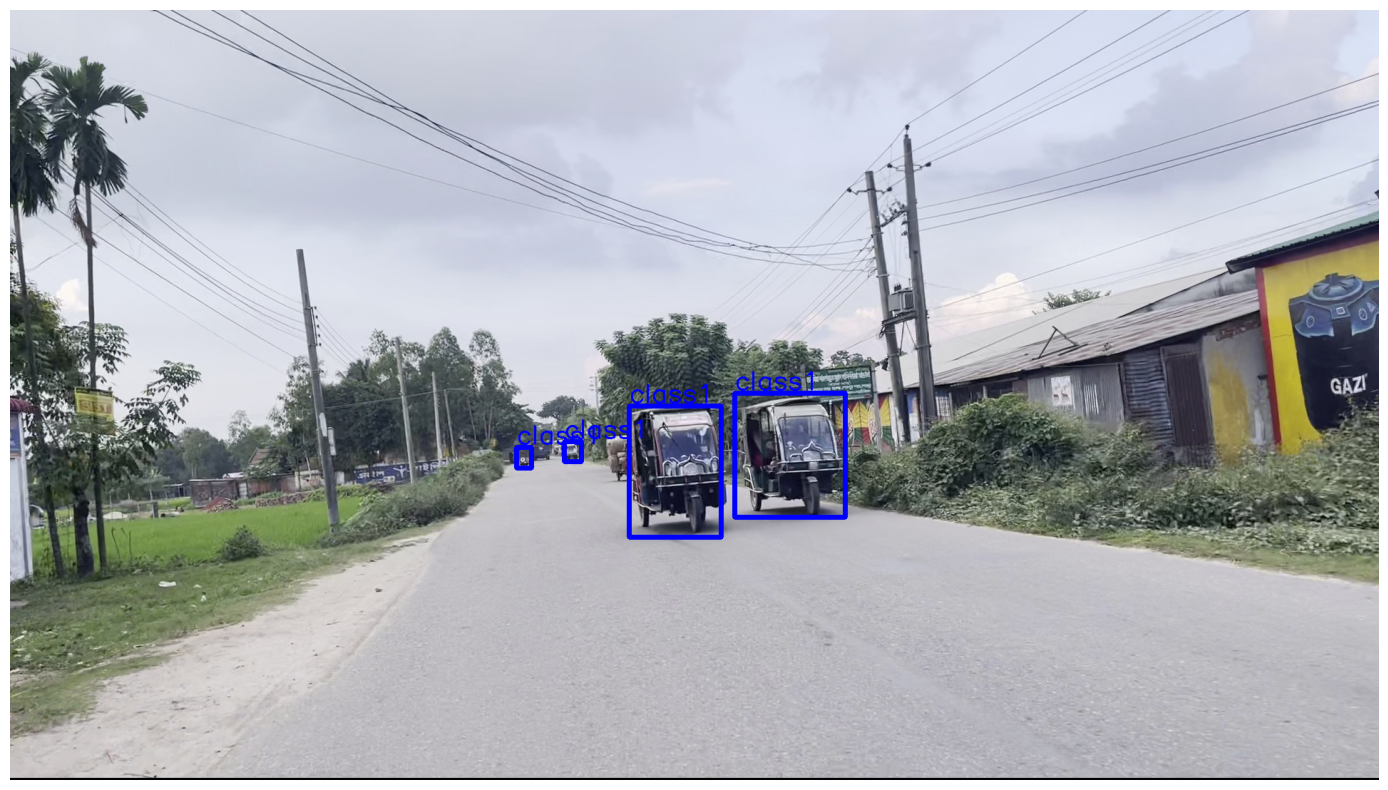

In [34]:
thickness = 5
font_scale = 1.2
font_thickness = 2

def generate_colors(num_classes):
    hsv_tuples = [(x / num_classes, 1., 1.) for x in range(num_classes)]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    return colors

def draw_boxes(image_path, df, class_labels=None):
    image = cv2.imread(image_path)

    if class_labels is None:
        class_labels = ['class1', 'class2']  # Default class labels

    colors = generate_colors(len(class_labels))
    class_color_map = {class_labels[i]: colors[i] for i in range(len(class_labels))}

    if 'class_label' in df.columns:
        for _, row in df.iterrows():
            box = eval(row['voc_bbox'])
            class_label = row['class_label']
            if class_label < len(class_labels):
                color = class_color_map[class_labels[class_label]]
                box = [int(coord) for coord in box]

                cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), color, thickness)
                cv2.putText(
                    image,
                    class_labels[class_label],
                    (box[0], box[1] - 5),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    font_scale,
                    color,
                    font_thickness
                )
            else:
                print(f"Warning: 'class_label' value {class_label} is out of range for class labels list.")
    else:
        print("Warning: 'class_label' column not found. Using default class labels.")

        for _, row in df.iterrows():
            box = eval(row['voc_bbox'])
            class_name = row['class_name'] if 'class_name' in df.columns else 'Unknown'
            color = class_color_map[class_name]
            box = [int(coord) for coord in box]

            cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), color, thickness)
            cv2.putText(
                image,
                class_name,
                (box[0], box[1] - 5),
                cv2.FONT_HERSHEY_SIMPLEX,
                font_scale,
                color,
                font_thickness
            )

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(20,10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()


image_id = train_df.sample().reset_index().loc[0, 'image_id']
image_path = '/content/dlenigma1/BadODD/images/train'
image_path = os.path.join(image_path, image_id + '.jpg')
df_image = train_df[train_df['image_id'] == image_id]
class_labels = ['class1', 'class2']
draw_boxes(image_path, df_image, class_labels)


## Outputing the data into csv

In [36]:


# Assuming train_df is your DataFrame
train_df.to_csv('train.csv', index=False)

# Sampling a row from the DataFrame
sampled_row = train_df.sample()

# Saving the sampled row to a CSV file
sampled_row.to_csv('sampled_row.csv', index=False)

# Now, if you want to display the sampled row
print("Sampled Row:")
print(sampled_row)


Sampled Row:
           image_id            voc_bbox         coco_bbox  \
16875  khulna4_8370  921, 188, 984, 286  921, 188, 63, 98   

                                               yolo_bbox  class_label  \
16875  0.744140625, 0.32916666666666666, 0.04921875, ...            9   

       image_height  image_width  
16875           720         1280  


In [37]:
# Set display options to show full DataFrame content
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Print the sampled row
print("Sampled Row:")
print(sampled_row)


Sampled Row:
           image_id            voc_bbox         coco_bbox                                          yolo_bbox  class_label  image_height  image_width
16875  khulna4_8370  921, 188, 984, 286  921, 188, 63, 98  0.744140625, 0.32916666666666666, 0.04921875, ...            9           720         1280


In [39]:
import seaborn as sns

## Exploratory Analysis

First few rows of the dataset:
   id                     ImageID                           PredictionString_pred
0   0                 dhaka4_3360  3.0 1.0 0.3484375 0.4222222222222222 0.1151041
1   1  chuadanga_sirajganj1_17040  3.0 1.0 0.3484375 0.4222222222222222 0.1151041
2   2  chuadanga_sirajganj1_20820  3.0 1.0 0.3484375 0.4222222222222222 0.1151041
3   3                dhaka2_32280  3.0 1.0 0.3484375 0.4222222222222222 0.1151041
4   4               sylhet1_38104  3.0 1.0 0.3484375 0.4222222222222222 0.1151041

Summary statistics:
             id
count  5.000000
mean   2.000000
std    1.581139
min    0.000000
25%    1.000000
50%    2.000000
75%    3.000000
max    4.000000

Missing values:
id                       0
ImageID                  0
PredictionString_pred    0
dtype: int64


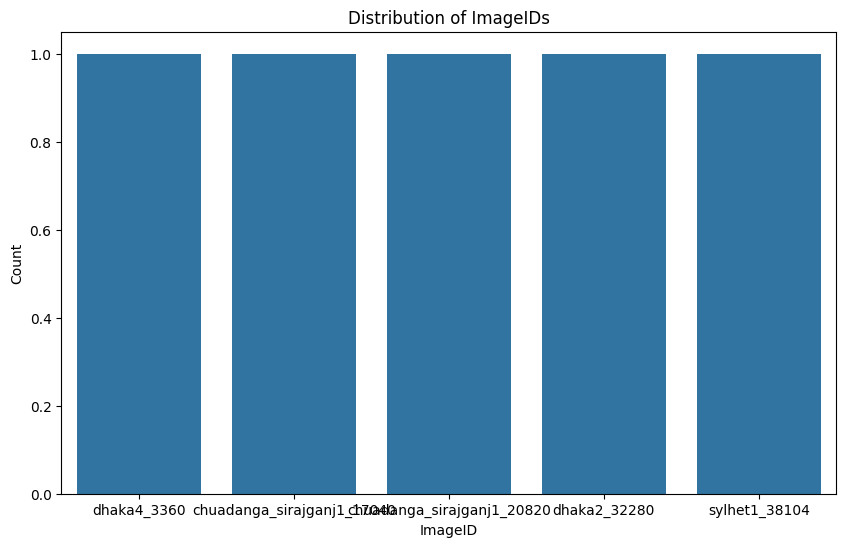

In [41]:

# Load the dataset
data = {
    'id': [0, 1, 2, 3, 4],
    'ImageID': ['dhaka4_3360', 'chuadanga_sirajganj1_17040', 'chuadanga_sirajganj1_20820', 'dhaka2_32280', 'sylhet1_38104'],
    'PredictionString_pred': ['3.0 1.0 0.3484375 0.4222222222222222 0.1151041', '3.0 1.0 0.3484375 0.4222222222222222 0.1151041', '3.0 1.0 0.3484375 0.4222222222222222 0.1151041', '3.0 1.0 0.3484375 0.4222222222222222 0.1151041', '3.0 1.0 0.3484375 0.4222222222222222 0.1151041']
}
df = pd.DataFrame(data)

# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(df)

# Summary statistics
print("\nSummary statistics:")
print(df.describe())

# Missing values
print("\nMissing values:")
print(df.isnull().sum())

# Distribution of classes
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='ImageID')
plt.title('Distribution of ImageIDs')
plt.xlabel('ImageID')
plt.ylabel('Count')
plt.show()
